In [200]:
import plotly.express as px
from tinyshift.series import trend_significance
from utilsforecast.preprocessing import fill_gaps
from utilsforecast.data import generate_series
from tinyshift.plot import corr_heatmap
import plotly.express as px
from utils import remove_leading_zeros, is_obsolete, forecastability, generate_lag
from tinyshift.plot import stationarity_check, seasonal_decompose, residual_check, pami
from tinyshift.series import fourier_seasonality
from scipy import signal
import holidays
import numpy as np
from statsforecast import StatsForecast
from utilsforecast.losses import rmse, mae, bias, cfe
from utilsforecast.evaluation import evaluate
from statsforecast.models import AutoARIMA, Naive, AutoETS, AutoTheta, AutoCES
import pandas as pd
import numpy as np
from tinyshift.modelling import filter_features_by_vif

In [201]:
df = generate_series(3, with_trend=True, static_as_categorical=False, seed=42, freq="D")

In [202]:
df.isnull().sum()

unique_id    0
ds           0
y            0
dtype: int64

In [203]:
df = fill_gaps(df, freq="D", end="per_serie", id_col="unique_id", time_col="ds")

In [204]:
df = df.groupby("unique_id")[df.columns].apply(remove_leading_zeros).reset_index(drop=True)

In [205]:
days_obsoletes=180
obsolete_series = df.groupby("unique_id")[df.columns].apply(is_obsolete, days_obsoletes)

In [206]:
obsolote_ids = obsolete_series[obsolete_series].index.tolist()

In [207]:
obsolote_ids

[]

In [208]:
df.groupby("unique_id")["y"].apply(trend_significance)

unique_id
0    (0.9894087777029937, 4.8574508252298796e-150)
1                         (0.998759437594496, 0.0)
2                        (0.9990776434701963, 0.0)
Name: y, dtype: object

In [209]:
px.line(df, x="ds", y="y", facet_col="unique_id")

In [210]:
px.line(df, x="ds", y="y", facet_col="unique_id")

In [211]:
df.groupby("unique_id")["y"].apply(forecastability)

unique_id                   
0          foreCA                                                  0.616734
           theoretical_limit                                       0.560748
           stability_index                                         0.937922
           adi_cv                                (1.0, 0.28499520299004516)
           hurst_exponent         (0.3290861603798452, 0.13218639190520123)
1          foreCA                                                  0.702415
           theoretical_limit                                        0.55557
           stability_index                                           0.9567
           adi_cv                                (1.0, 0.31390442751597913)
           hurst_exponent       (0.28893923895853546, 0.032089718874560705)
2          foreCA                                                  0.691794
           theoretical_limit                                       0.558174
           stability_index                                 

In [212]:
df["lag_1"] = df.groupby("unique_id")["y"].transform(generate_lag)
df["detrend"] = df.groupby("unique_id")["y"].transform(signal.detrend)
df["detrend_lag_7"] = df.groupby("unique_id")["detrend"].transform(generate_lag, lag=7)

# ACF/PACF

In [213]:
df = df.set_index("ds")

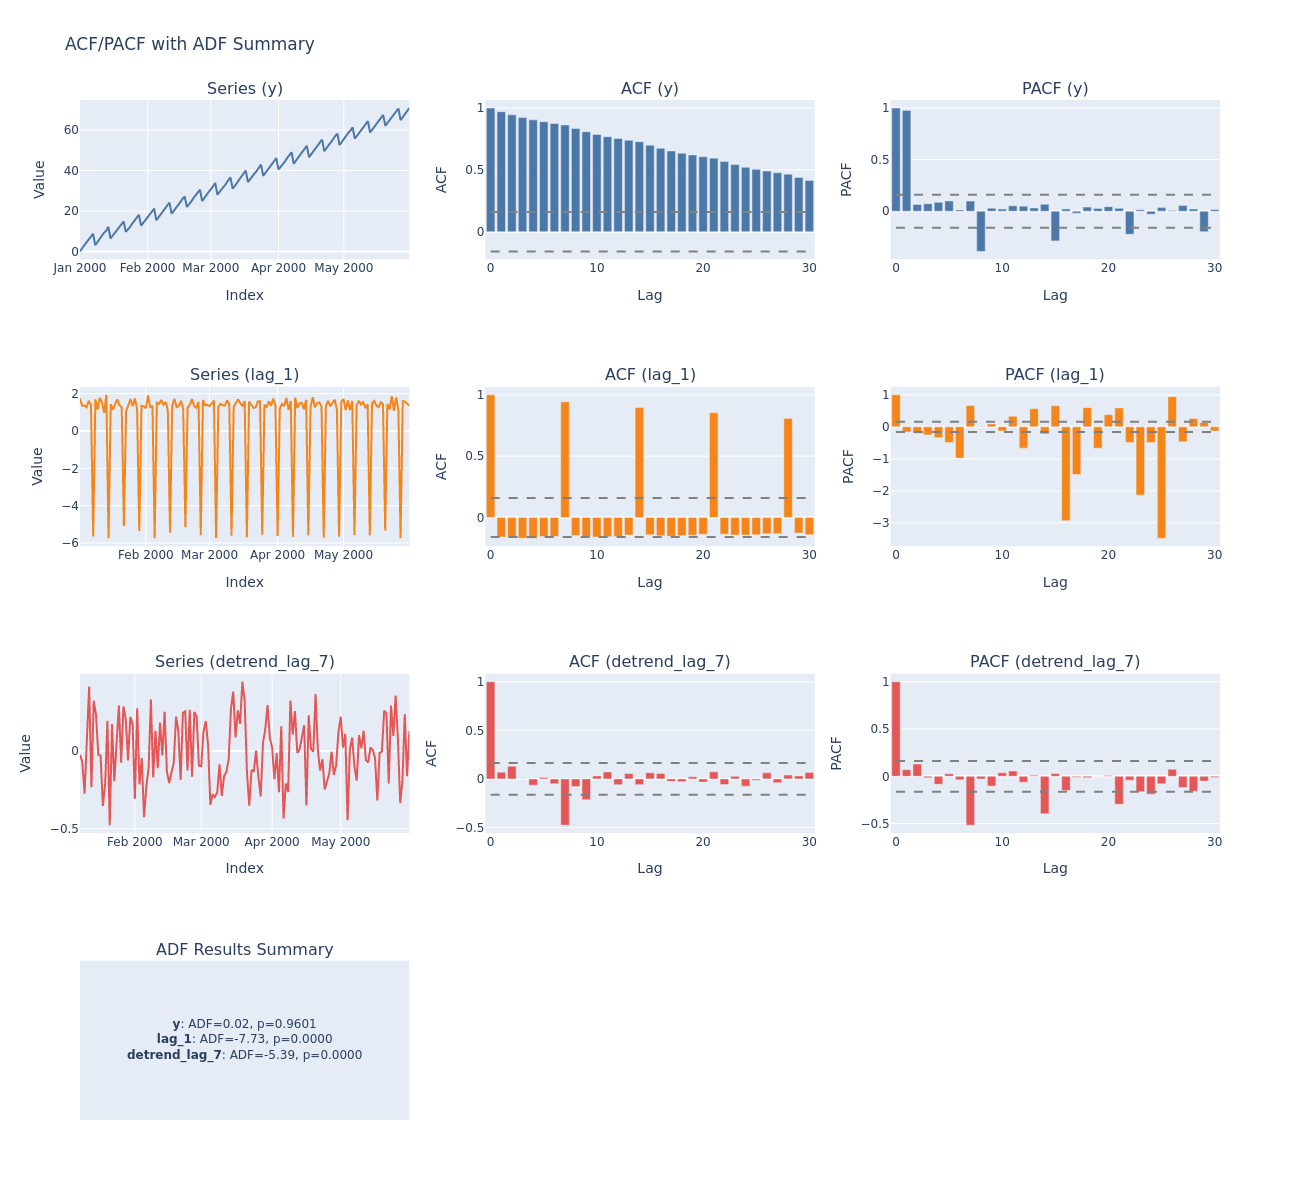

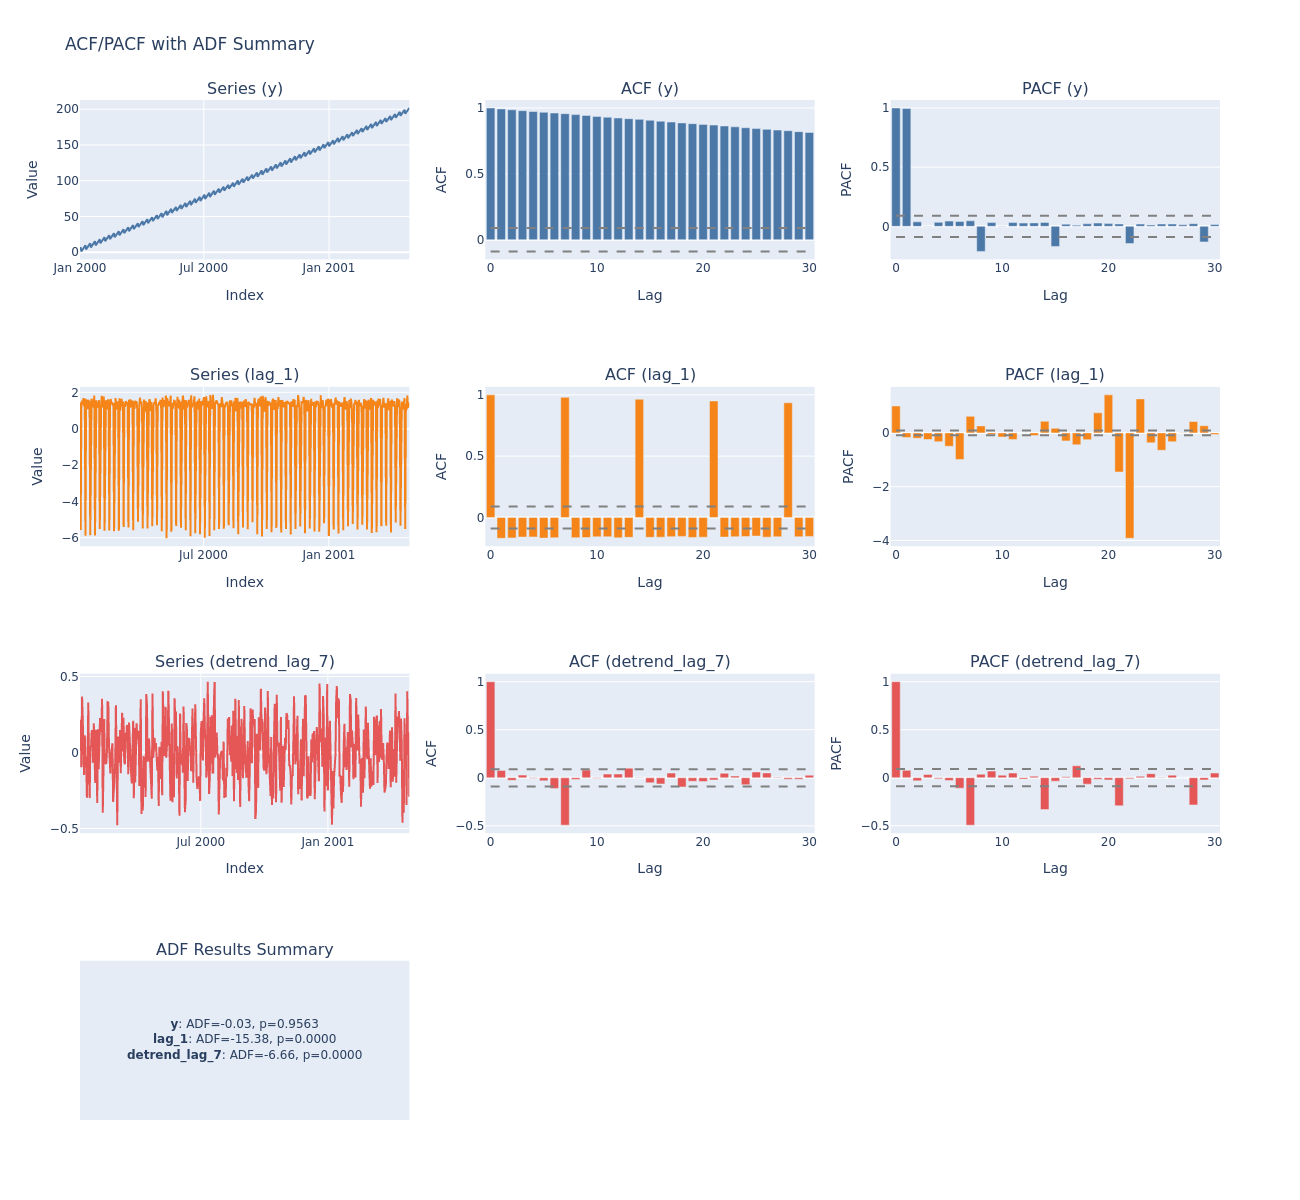

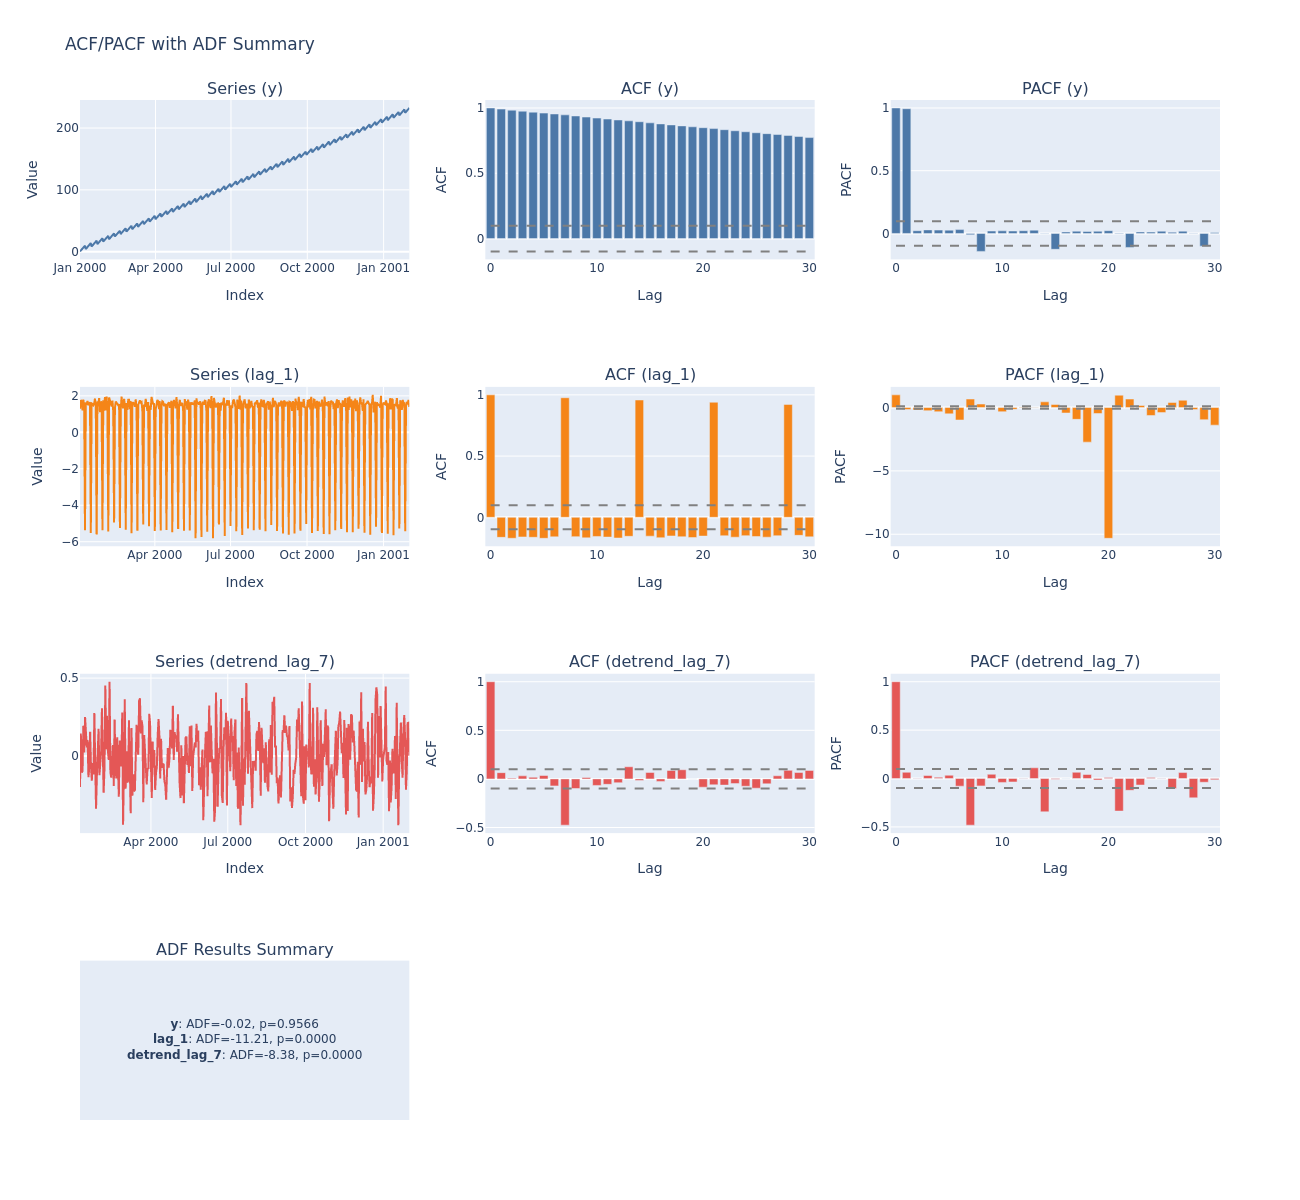

In [214]:
for id in df["unique_id"].unique():
    stationarity_check(df.loc[df["unique_id"] == id, ["y", "lag_1", "detrend_lag_7"]], fig_type="png")

# STL

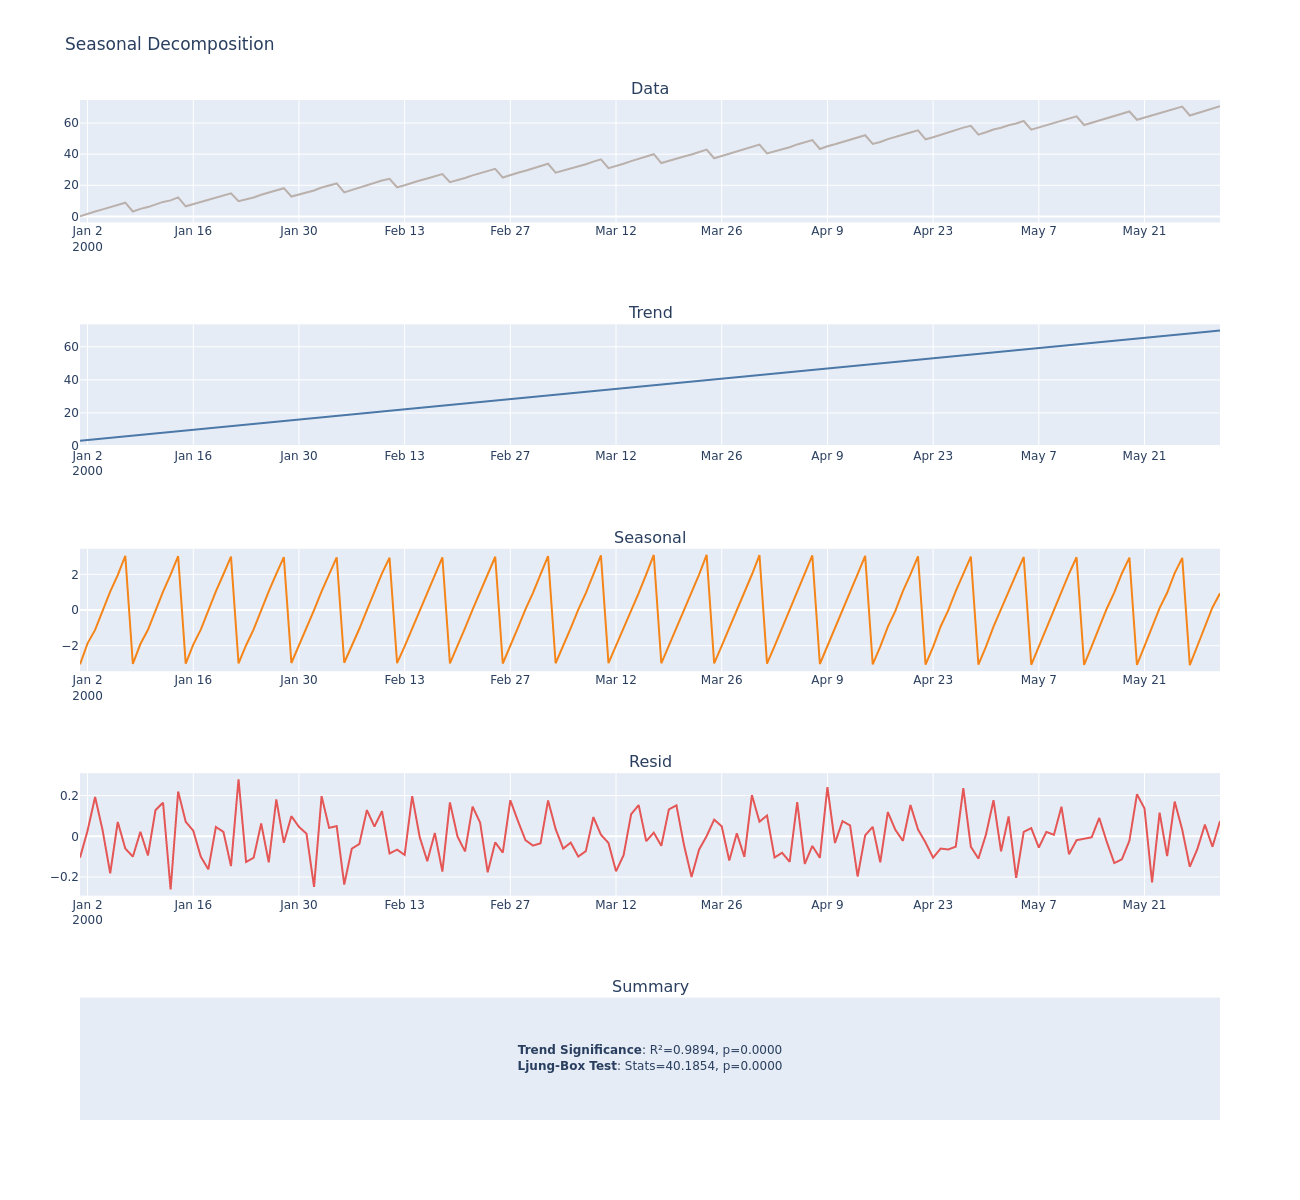

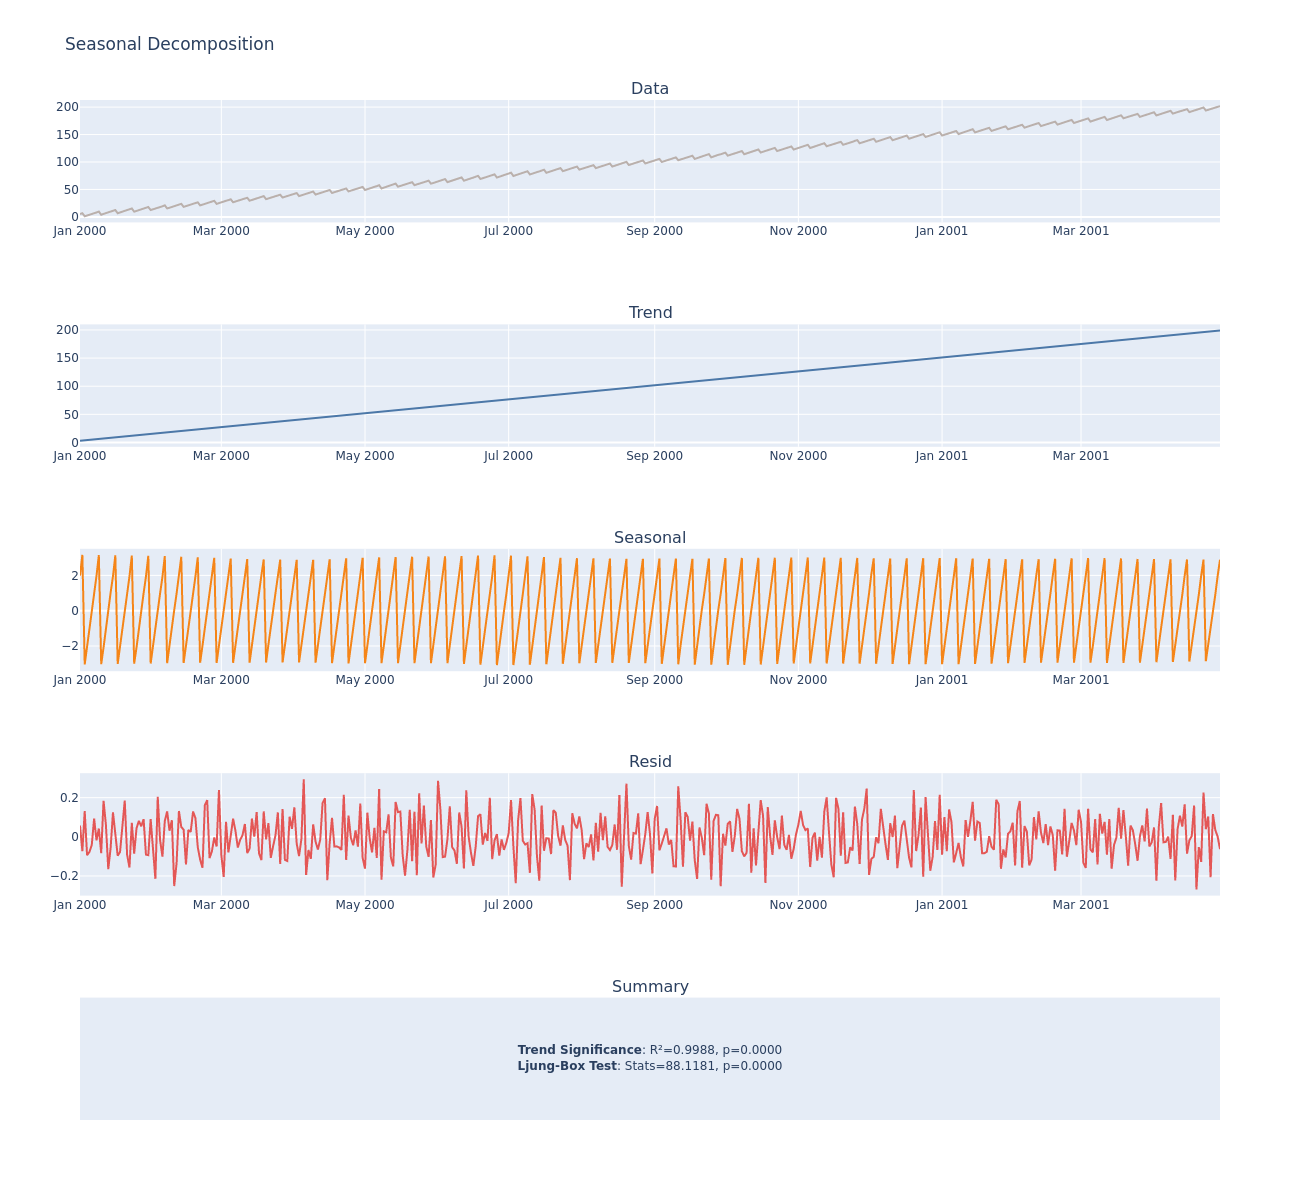

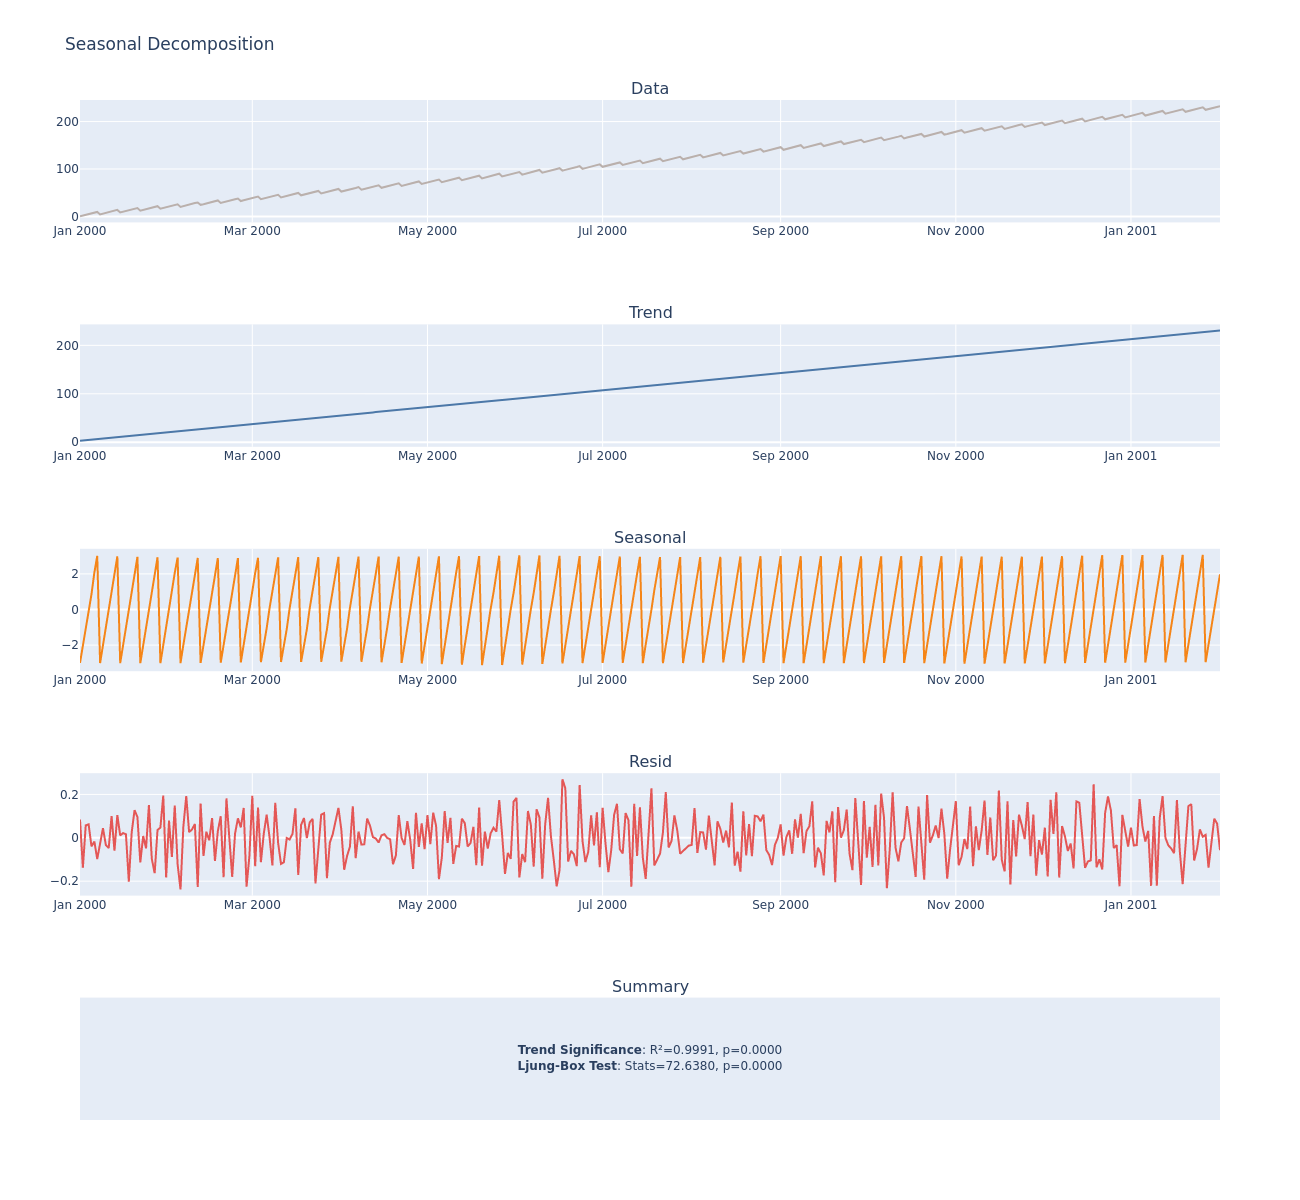

In [215]:
for id in df["unique_id"].unique():
    seasonal_decompose(
        df[df["unique_id"] == id]["y"],
        fig_type="png",
        periods=7,
    )

# PAMI

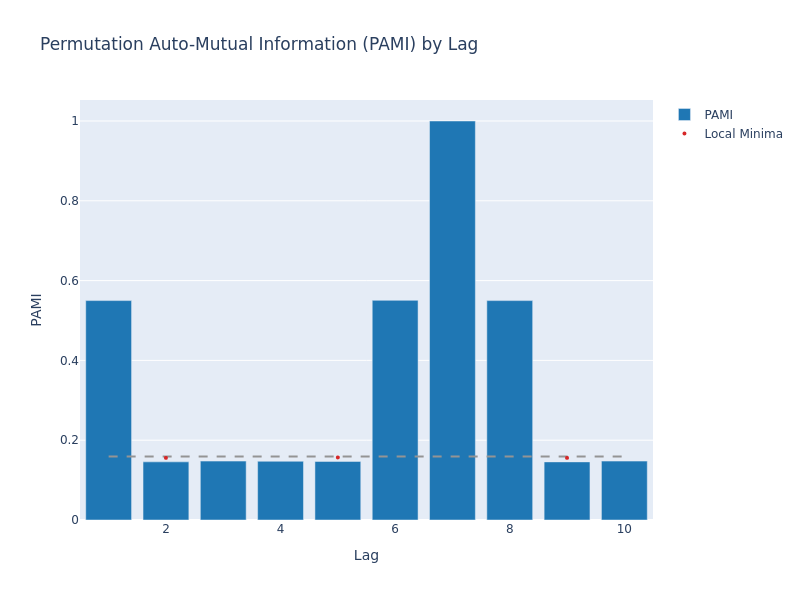

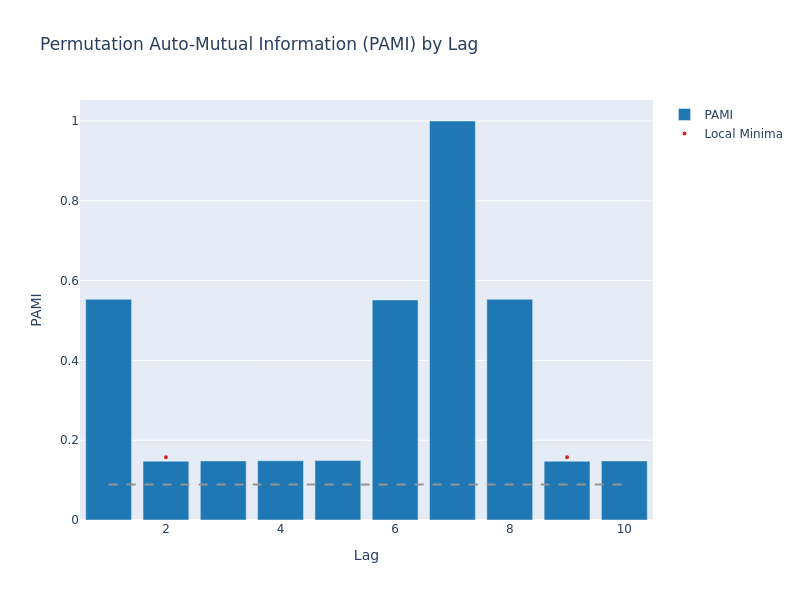

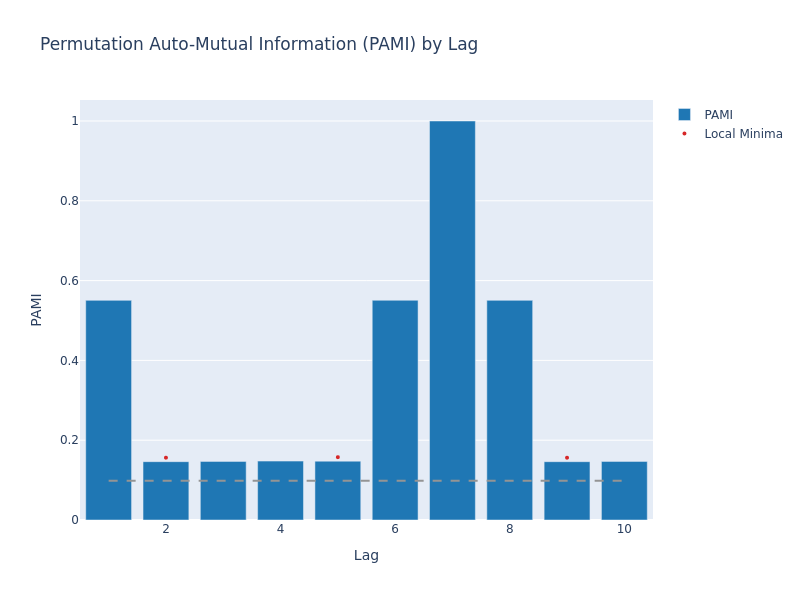

In [216]:
for id in df["unique_id"].unique():
    pami(df.loc[df["unique_id"] == id, "y"], nlags=10, m=3, delay=1, normalize=True, fig_type="png")

## Features
- ~~Holidays~~
- ~~Série de fourier para padrões cíclicos (seno e cosseno) - dia da semana, dia do ano~~
- ~~mês~~
- ~~fim do mês~~
- ~~Lags~~
- Rolling Windows: médias, desvio padrão e permutação da entropia

In [217]:
df = fourier_seasonality(df.reset_index(), "ds", seasonality=["weekly", "yearly"])
holidays_br = holidays.country_holidays("Brazil")
df["is_holiday"] = np.array([timestamp in holidays_br for timestamp in df["ds"]])
df["is_month_end"] = df["ds"].dt.is_month_end

In [218]:
df = df.dropna()

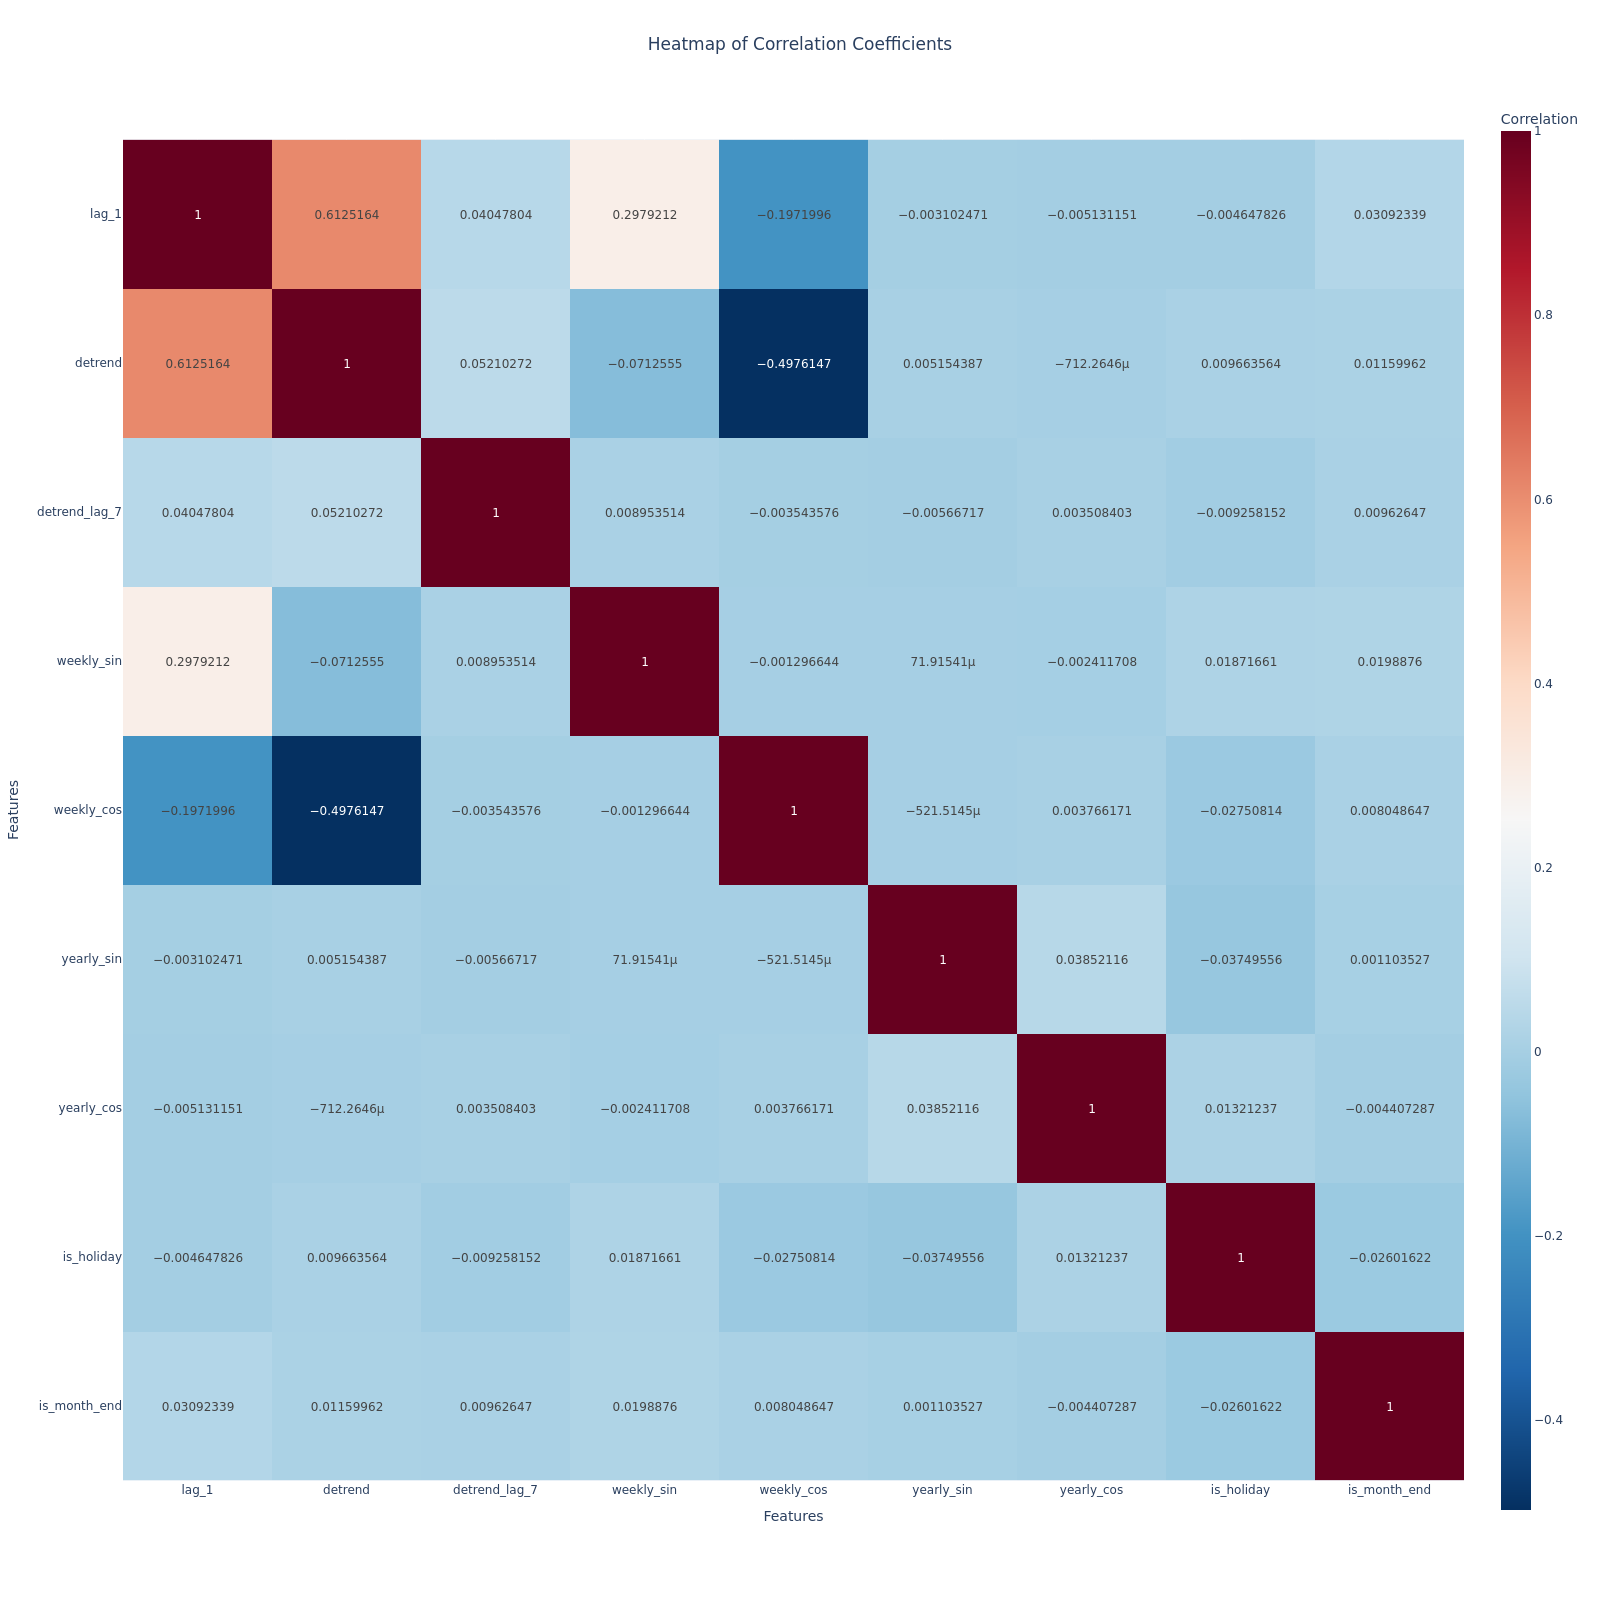

In [219]:
corr_heatmap(df[df.columns[3:]], fig_type="png")

In [220]:
df.drop(columns=["lag_1", "detrend", "detrend_lag_7"], inplace=True)

# Modelagem Estatística

In [221]:
seasonal_length = 7
sf = StatsForecast(
    models=[
        AutoARIMA(season_length=seasonal_length),
        AutoETS(season_length=seasonal_length),
        AutoTheta(season_length=seasonal_length),
        AutoCES(season_length=seasonal_length),
    ],
    freq='D',
    fallback_model=Naive(),
    n_jobs=-1
)

In [222]:
horizon = 30
train = df.groupby('unique_id').head(-horizon).reset_index(drop=True)
test = df.groupby('unique_id').tail(horizon).reset_index(drop=True)

In [223]:
def wape(actual, forecast):
    return np.sum(np.abs(actual - forecast)) / np.sum(np.abs(actual))

In [224]:
fc = sf.forecast(df=train[["unique_id", "ds", "y"]], h=horizon) #fit_predict

In [225]:
metrics = [
    mae,
    rmse,
    bias,
    cfe
]
models = ["AutoARIMA", "AutoETS", "AutoTheta", "CES", "Ensemble"]
scum = ["AutoARIMA", "AutoETS", "AutoTheta", "CES"]

In [226]:
fc["Ensemble"] = fc[scum].median(axis=1)
fc.loc[fc["Ensemble"] < 1e-1, "Ensemble"] = 0

In [227]:
test = pd.merge(test, fc, on=["unique_id", "ds"], how="inner")
columns = ["unique_id", 
               "ds", 
               "y", 
               "AutoARIMA", 
               "AutoETS", 
               "AutoTheta", 
               "CES", 
               "Ensemble"]

In [228]:
test.groupby("unique_id")[test.columns].apply(lambda x: wape(x["y"], x["Ensemble"]))

unique_id
0    0.011617
1    0.001238
2    0.001326
dtype: float64

In [229]:
test.groupby("unique_id")[test.columns].apply(lambda x: wape(x["y"], x["AutoARIMA"]))

unique_id
0    0.001863
1    0.000636
2    0.000530
dtype: float64

In [230]:
evaluate(test[columns], 
         metrics=metrics, 
         models=models, 
         id_col="unique_id", 
         time_col="ds", 
         target_col="y")

unique_id metric  AutoARIMA   AutoETS  AutoTheta         CES   Ensemble
0           0    mae   0.118204  0.117160   2.817782    4.788348   0.736980
1           1    mae   0.122864  0.127738   4.450999    0.553172   0.239391
2           2    mae   0.117889  0.121499   4.293438    0.793892   0.294835
3           0   rmse   0.143891  0.136838   3.266078    5.625206   1.137482
4           1   rmse   0.141319  0.148544   5.085648    0.661118   0.315662
5           2   rmse   0.145919  0.152464   4.885838    0.914052   0.399064
6           0   bias   0.047541  0.021202   0.676148    4.788348   0.709622
7           1   bias   0.017623  0.023643   0.722320    0.546096   0.180858
8           2   bias  -0.004643  0.036408   0.834656    0.784464   0.255051
9           0    cfe   1.426229  0.636056  20.284450  143.650430  21.288656
10          1    cfe   0.528704  0.709280  21.669605   16.382889   5.425739
11          2    cfe  -0.139288  1.092242  25.039679   23.533923   7.651520

# Análise de Resíduo

In [231]:
test["residual_arima"] = test["y"] - test["AutoARIMA"]
test["residual_ets"] = test["y"] - test["AutoETS"]
test["residual_autotheta"] = test["y"] - test["AutoTheta"]
test["residual_ces"] = test["y"] - test["CES"]
test["residual_ensemble"] = test["y"] - test["Ensemble"]

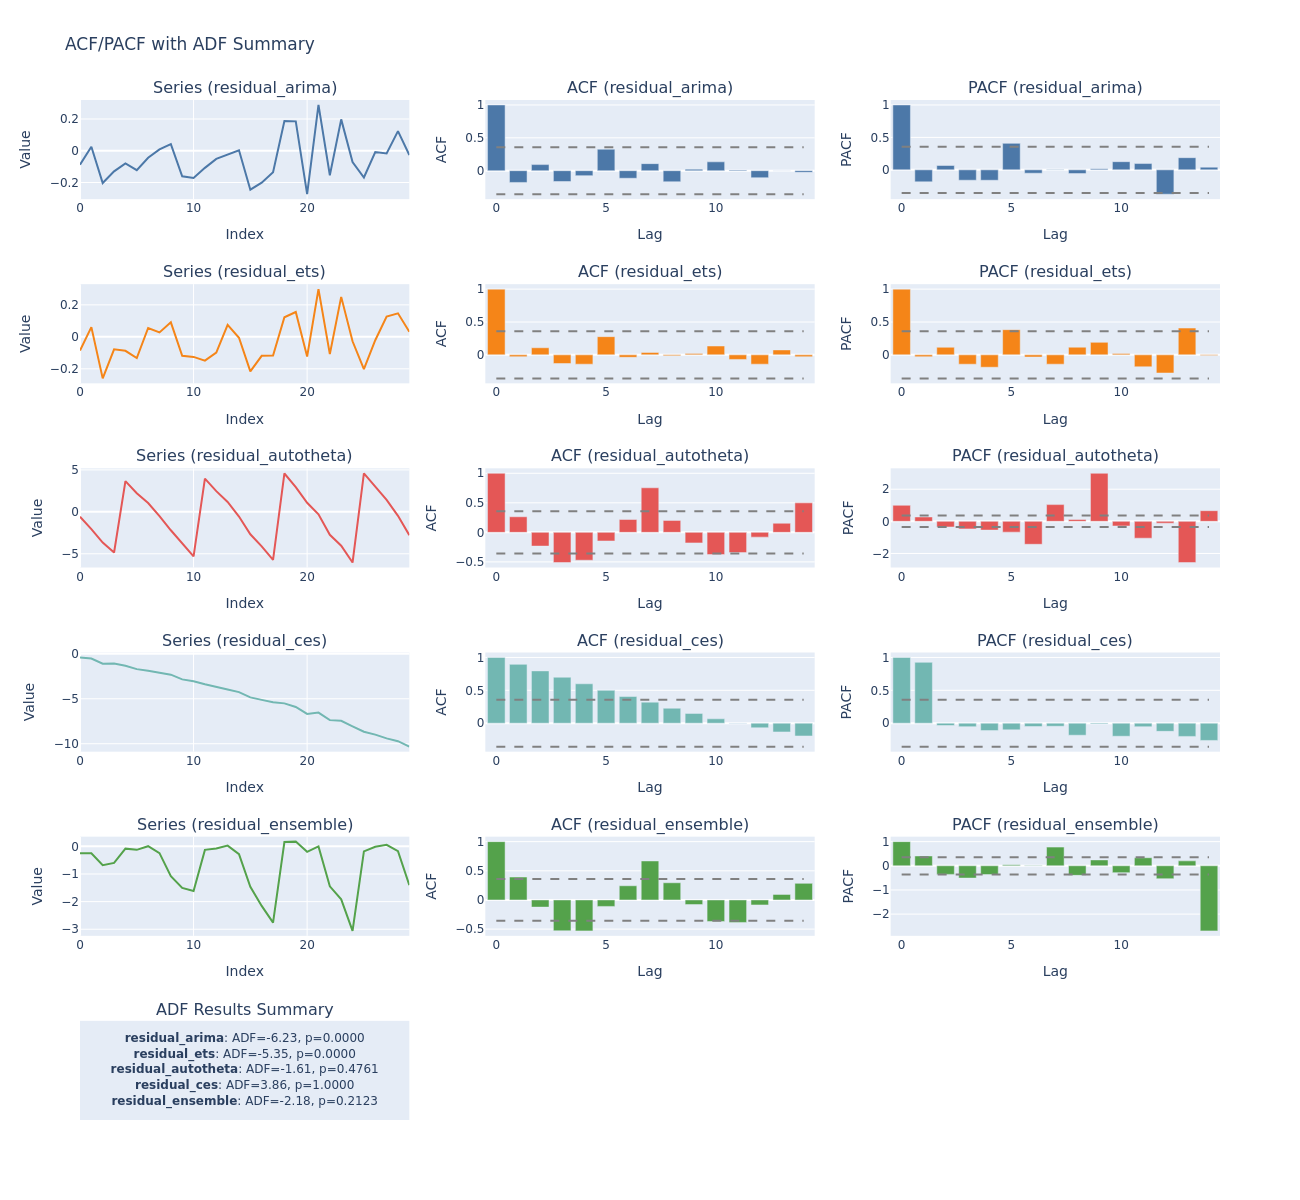

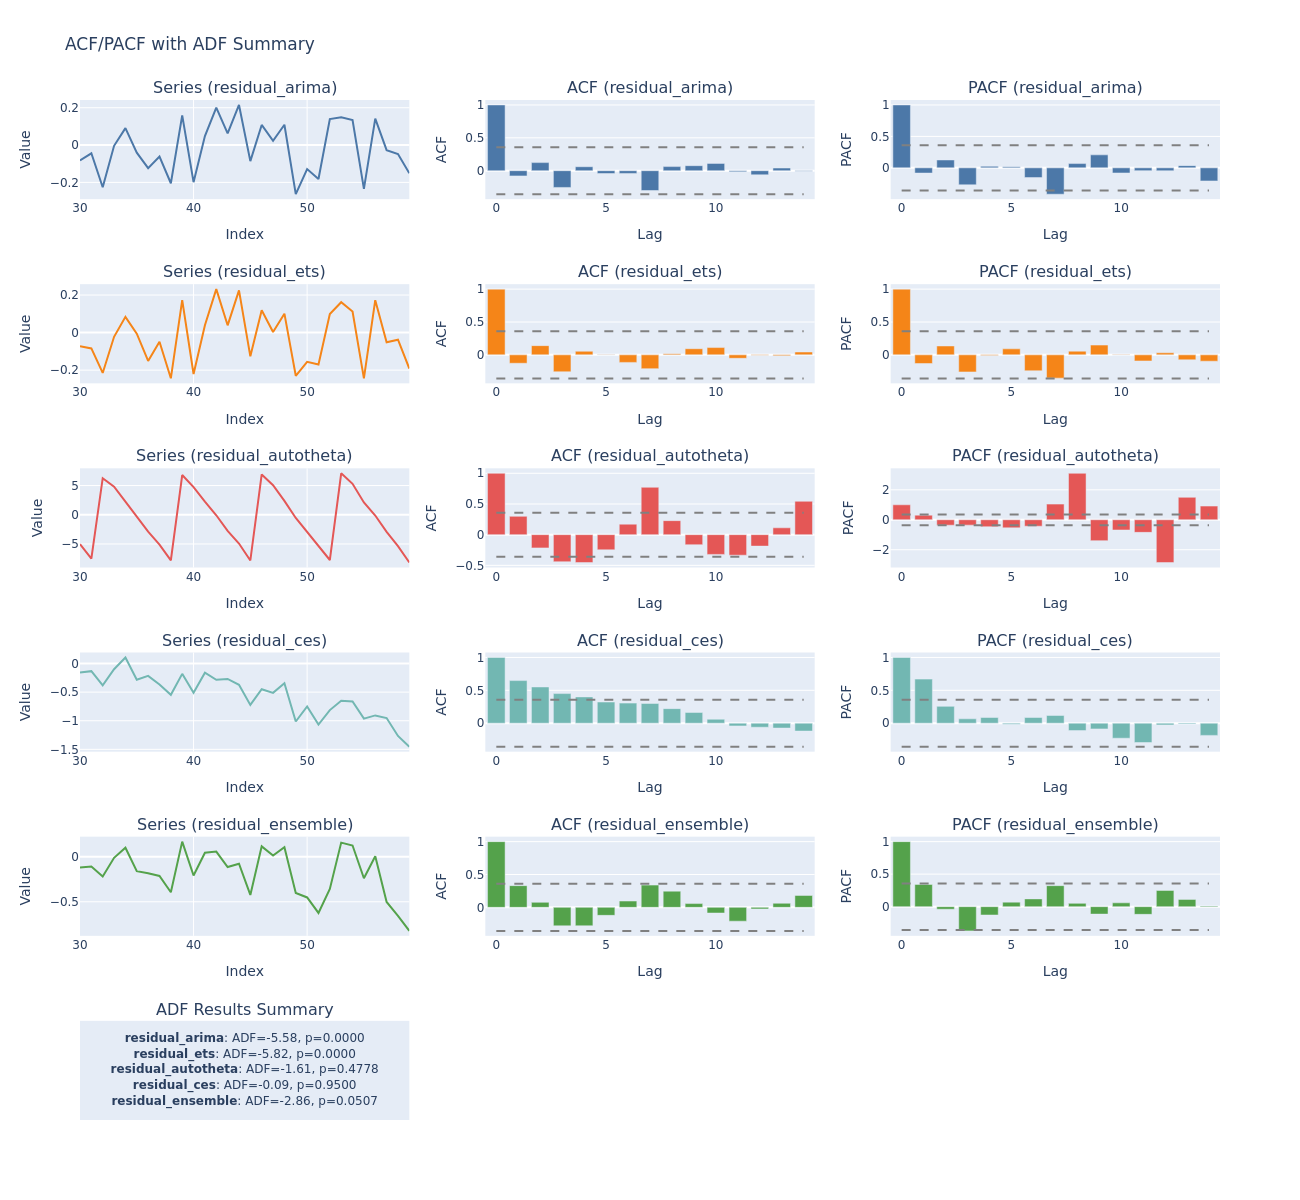

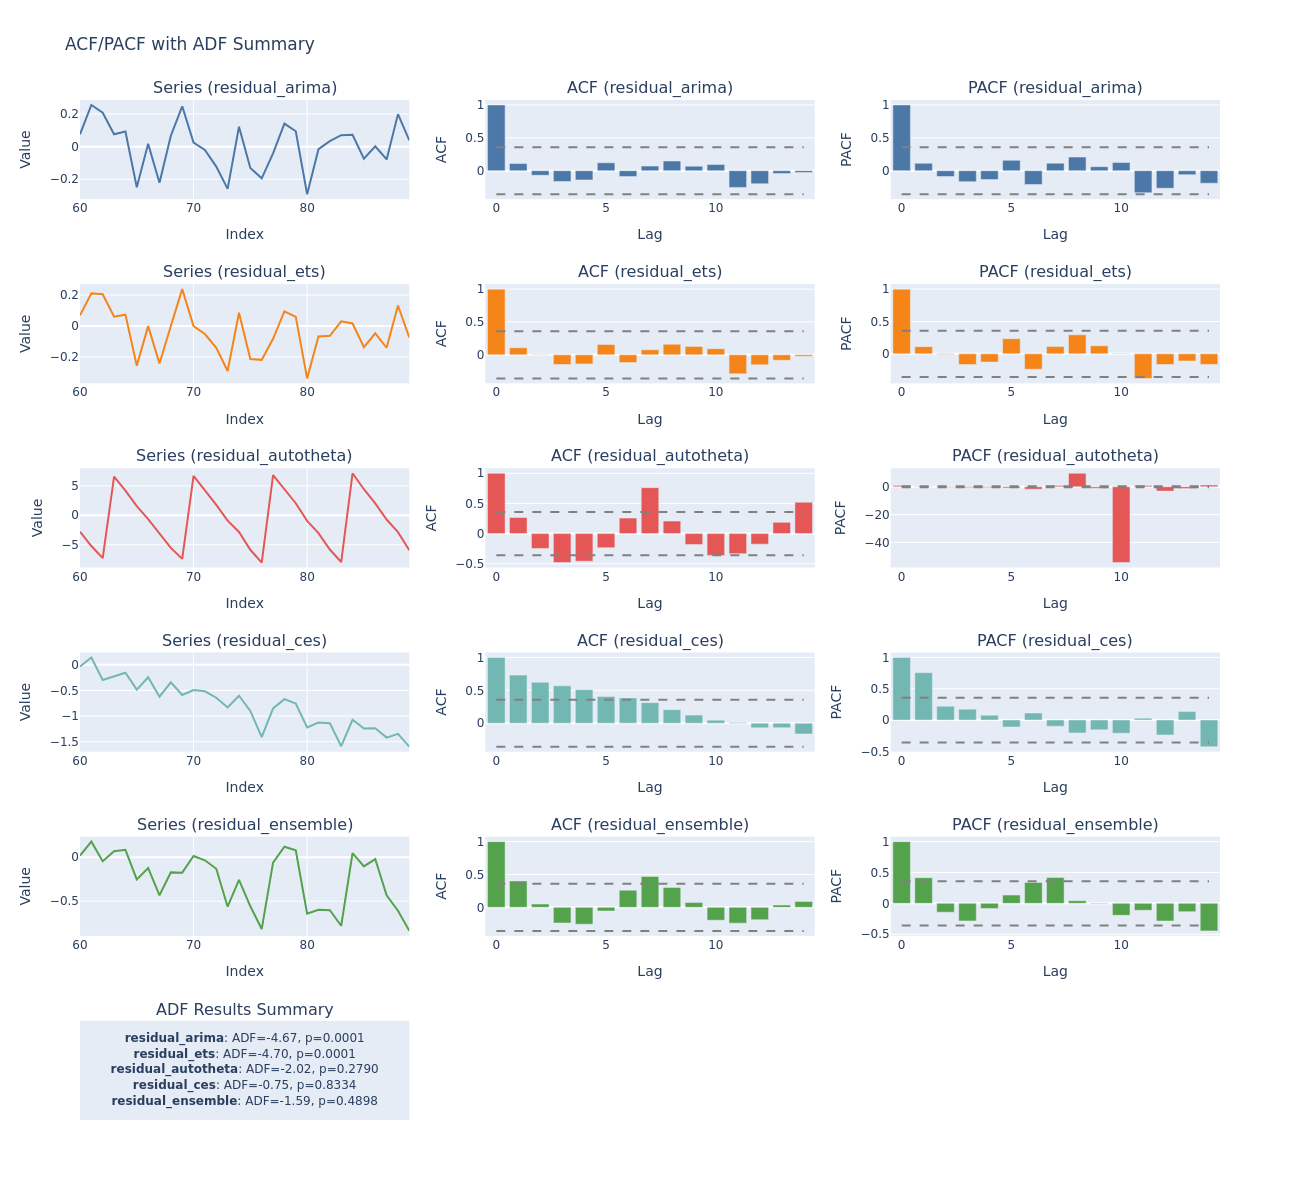

In [232]:
for id in test["unique_id"].unique():
    stationarity_check(test.loc[test["unique_id"] == id, ["residual_arima", "residual_ets", "residual_autotheta", "residual_ces", "residual_ensemble"]], nlags=30, fig_type="png")

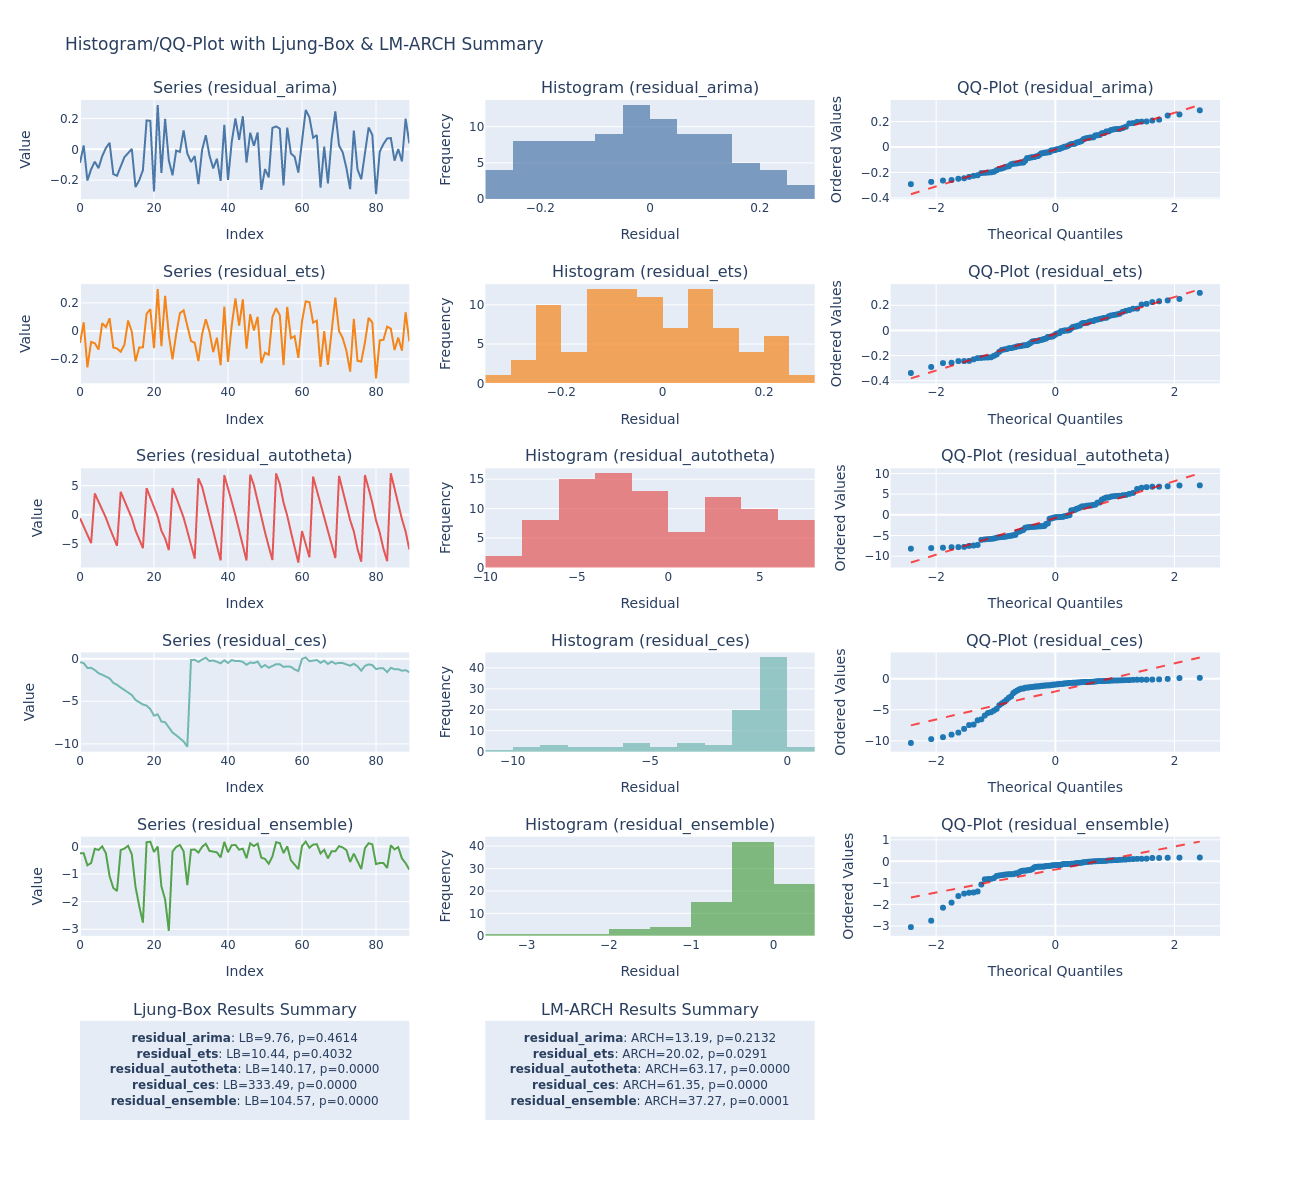

In [233]:
residual_check(test[["residual_arima", "residual_ets", "residual_autotheta", "residual_ces", "residual_ensemble"]], fig_type="png")

# Machine Learning (Linear Regression & Random Forest)

In [234]:
from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean, Offset, Combine
from mlforecast.target_transforms import Differences, LocalStandardScaler
from scipy import signal
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from mlforecast.lag_transforms import RollingStd
from mlforecast.target_transforms import Differences

In [235]:
import numpy as np
from numba import njit

@njit
def hampel_filter(
    x: np.ndarray,
    window_size: int,
    factor: float = 3.0,
    scale: float = 1.4826,
) -> np.ndarray:
    """
    Identify outliers using a Numba-compiled implementation of the Hampel filter.

    The Hampel filter is a robust outlier detection method that uses the median and
    median absolute deviation (MAD) of a rolling window to identify points that
    deviate significantly from the local trend. This version is compiled with Numba
    for high-performance execution and compatibility with the Nixtla ecosystem.

    Parameters
    ----------
    x : ndarray of shape (n_samples,)
        Input 1D data to be filtered.
    window_size : int
        Size of the rolling window (must be odd and >= 3).
    factor : float, default=3.0
        Recommended values for common distributions (95% confidence):
        - Normal distribution: 3.0 (default)
        - Laplace distribution: 2.3
        - Cauchy distribution: 3.4
        - Exponential distribution: 3.6
        - Uniform distribution: 3.9
        Number of scaled MADs from the median to consider as outlier.
    scale : float, default=1.4826
        Scaling factor for MAD to make it consistent with standard deviation.
        Recommended values for different distributions:
        - Normal distribution: 1.4826 (default)
        - Uniform distribution: 1.16
        - Laplace distribution: 2.04
        - Exponential distribution: 2.08
        - Cauchy distribution: 1.0 (MAD is already consistent)

    Returns
    -------
    is_outlier : ndarray of shape (n_samples,)
        Boolean array indicating outliers (True) and inliers (False).

    Notes
    -----
    This function is JIT-compiled with Numba for optimal performance in the
    Nixtla ecosystem.
    """

    if window_size < 3 or window_size % 2 == 0:
        pass

    n = len(x)
    is_outlier = np.zeros(n, dtype=np.bool_)

    for i in range(n):
        start = max(0, i - window_size + 1)
        end = i + 1

        window = x[start:end]

        if len(window) < window_size:
            continue

        window_no_nan = window[~np.isnan(window)]

        if len(window_no_nan) < window_size:
            continue

        median = np.median(window_no_nan)
        mad = np.median(np.abs(window_no_nan - median))
        threshold = factor * mad * scale

        current_value = x[i]

        if np.isnan(current_value):
            continue

        if np.abs(current_value - median) > threshold:
            is_outlier[i] = True

    return is_outlier


In [236]:
models = [LinearRegression(), RandomForestRegressor(random_state=42, n_jobs=-1, max_depth=int(np.ceil(np.log2(len(train)) - 1)))]

mf = MLForecast(
    models=models,
    freq='D',
    lags=[7],
    lag_transforms={
        1: [
        (hampel_filter, 3) # Detecta saltos em janela de 3 dias
        ],
    },
    target_transforms=[LocalStandardScaler(), Differences([7])],
)

mf.fit(train, static_features=[])

MLForecast(models=[LinearRegression, RandomForestRegressor], freq=D, lag_features=['lag7', 'hampel_filter_lag1_window_size3'], date_features=[], num_threads=1)

In [237]:
test.drop(columns=["AutoARIMA", "AutoETS", "AutoTheta", "CES", "Ensemble"], inplace=True)

In [238]:
test.drop(columns=["residual_arima", "residual_ets", "residual_autotheta", "residual_ces", "residual_ensemble"], inplace=True)

In [239]:
res = mf.predict(h=30, X_df=test[["unique_id", "ds", "weekly_sin", "weekly_cos", "yearly_sin", "yearly_cos", "is_holiday", "is_month_end"]])

In [240]:
res["y"] = test["y"]

In [241]:
evaluate(res, 
         metrics=metrics, 
         models=["LinearRegression", "RandomForestRegressor"], 
         id_col="unique_id", 
         time_col="ds", 
         target_col="y")

unique_id metric  LinearRegression  RandomForestRegressor
0           0    mae          0.553002               0.146611
1           1    mae          0.399331               0.123153
2           2    mae          0.543620               0.193616
3           0   rmse          0.691382               0.192863
4           1   rmse          0.502898               0.161268
5           2   rmse          0.706682               0.246538
6           0   bias         -0.336233               0.070939
7           1   bias         -0.135259              -0.011942
8           2   bias          0.341845              -0.104650
9           0    cfe        -10.087003               2.128165
10          1    cfe         -4.057771              -0.358246
11          2    cfe         10.255338              -3.139491

In [242]:
def standardize_coefficients(model: LinearRegression, df_train: pd.DataFrame, target="y"):
    """
    Standardize the coefficients of the model based on the standard deviation of the features and target.
    """
    std_coef = np.zeros(len(model.coef_))
    for i in range(len(model.feature_names_in_)):
        std_coef[i] = model.coef_[i] * df_train[model.feature_names_in_[i]].std() / df_train[target].std()
    return std_coef

In [243]:
feature_importance = pd.DataFrame({
    'feature': mf.models_["LinearRegression"].feature_names_in_,
    'std_coef': standardize_coefficients(mf.models_["LinearRegression"], mf.preprocess(train, static_features=[]))
}).sort_values(by='std_coef', ascending=False).reset_index(drop=True)

In [244]:
feature_importance

feature  std_coef
0                             lag7  0.974365
1                       yearly_sin  0.007112
2                       is_holiday  0.004097
3                       yearly_cos  0.003608
4                       weekly_cos  0.001090
5                       weekly_sin  0.000905
6                     is_month_end -0.003244
7  hampel_filter_lag1_window_size3 -0.007588

In [245]:
test["residual_LR"] = res["y"] - res["LinearRegression"]
test["residual_RF"] = res["y"] - res["RandomForestRegressor"]

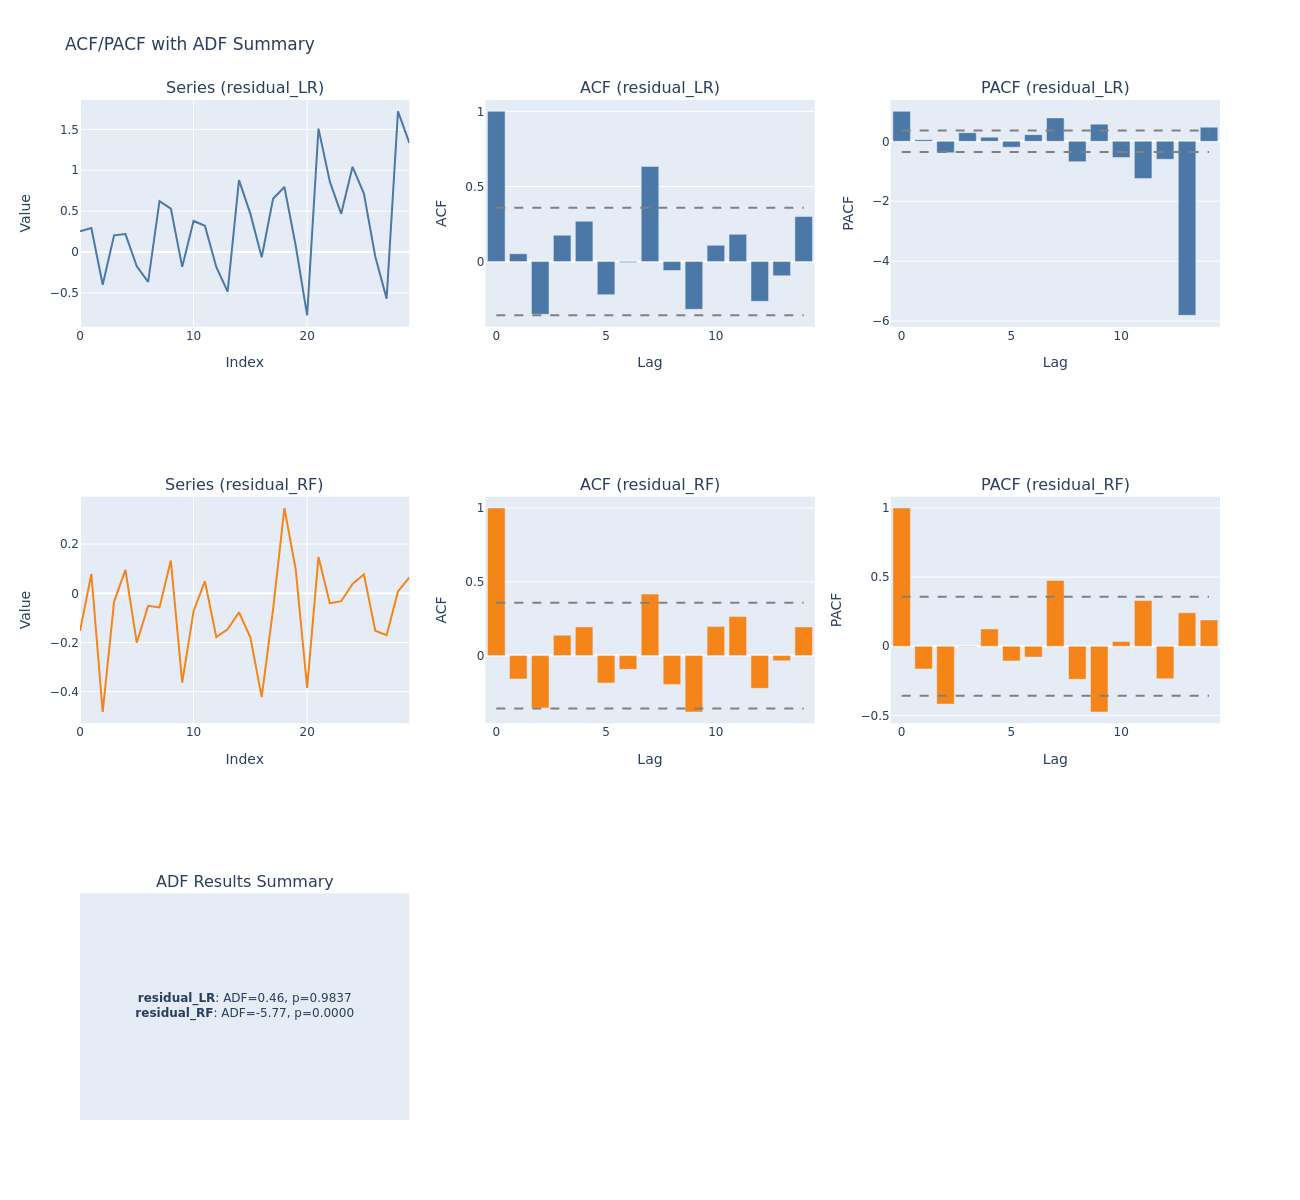

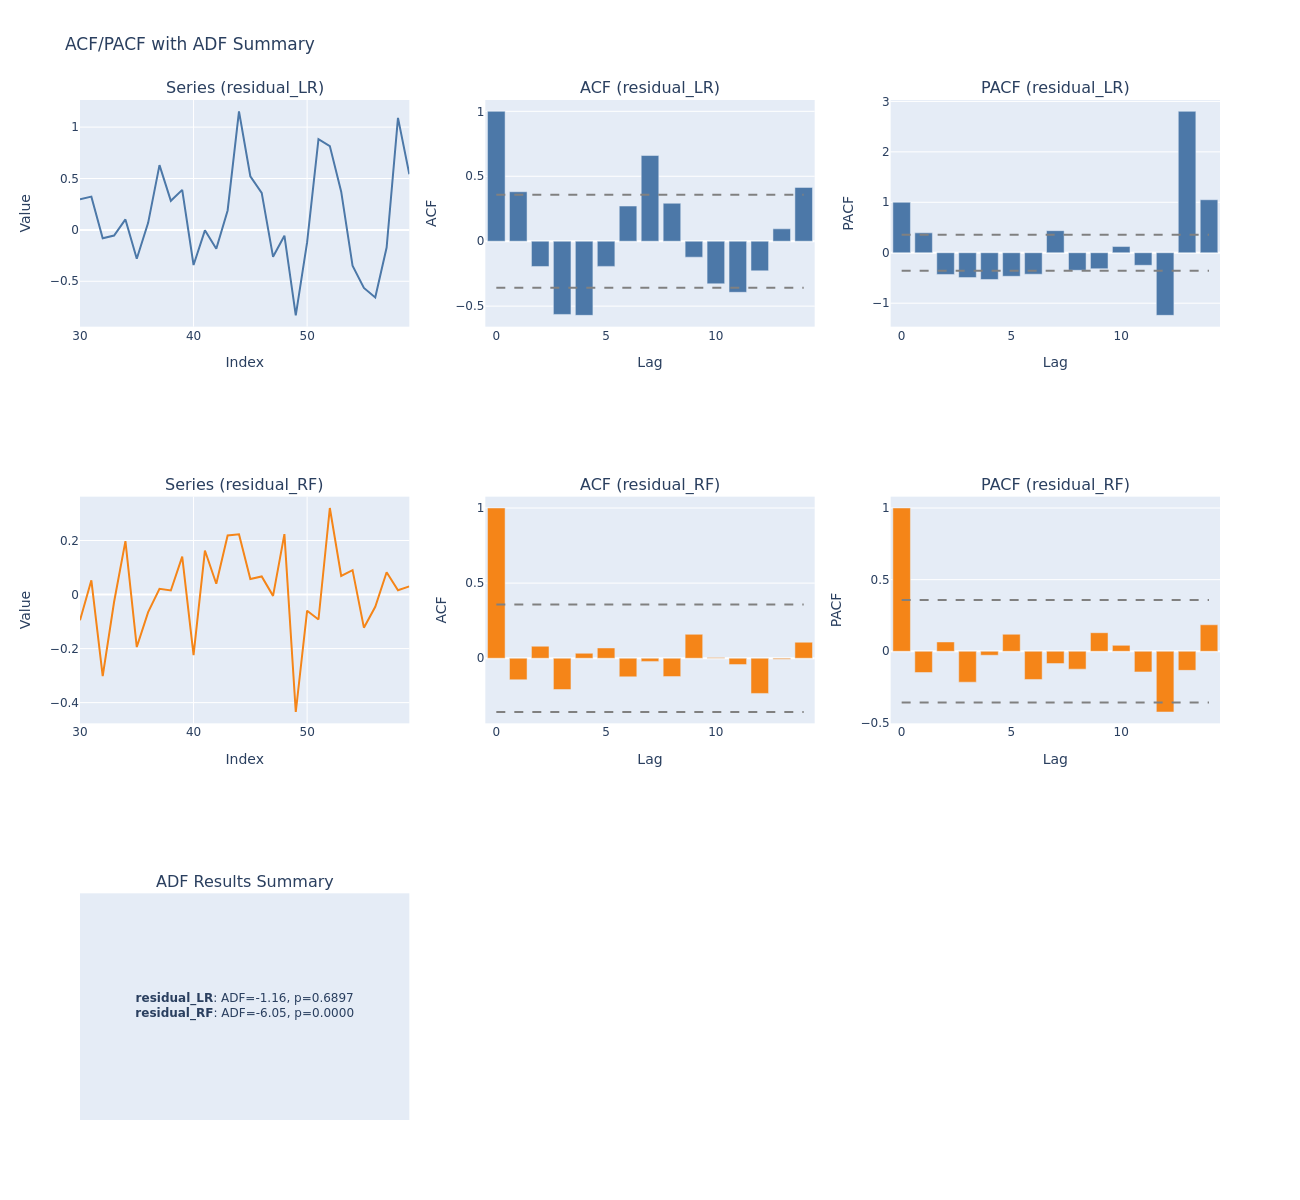

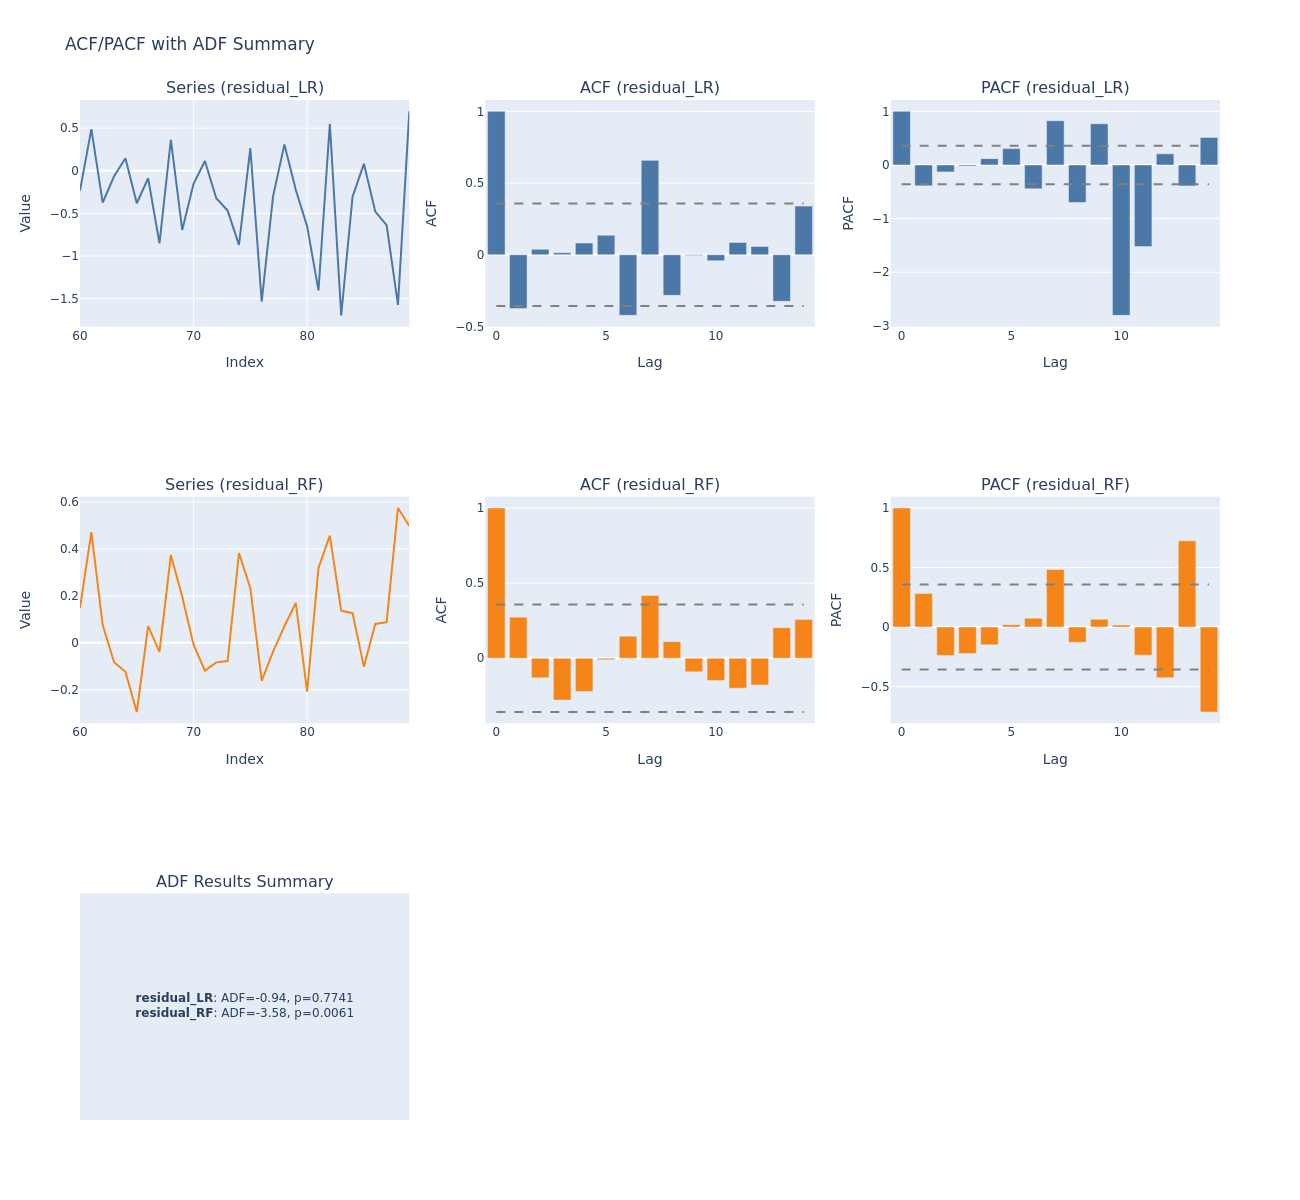

In [246]:
for id in test["unique_id"].unique():
    stationarity_check(test.loc[test["unique_id"] == id, ["residual_LR", "residual_RF"]], nlags=30, fig_type="png")

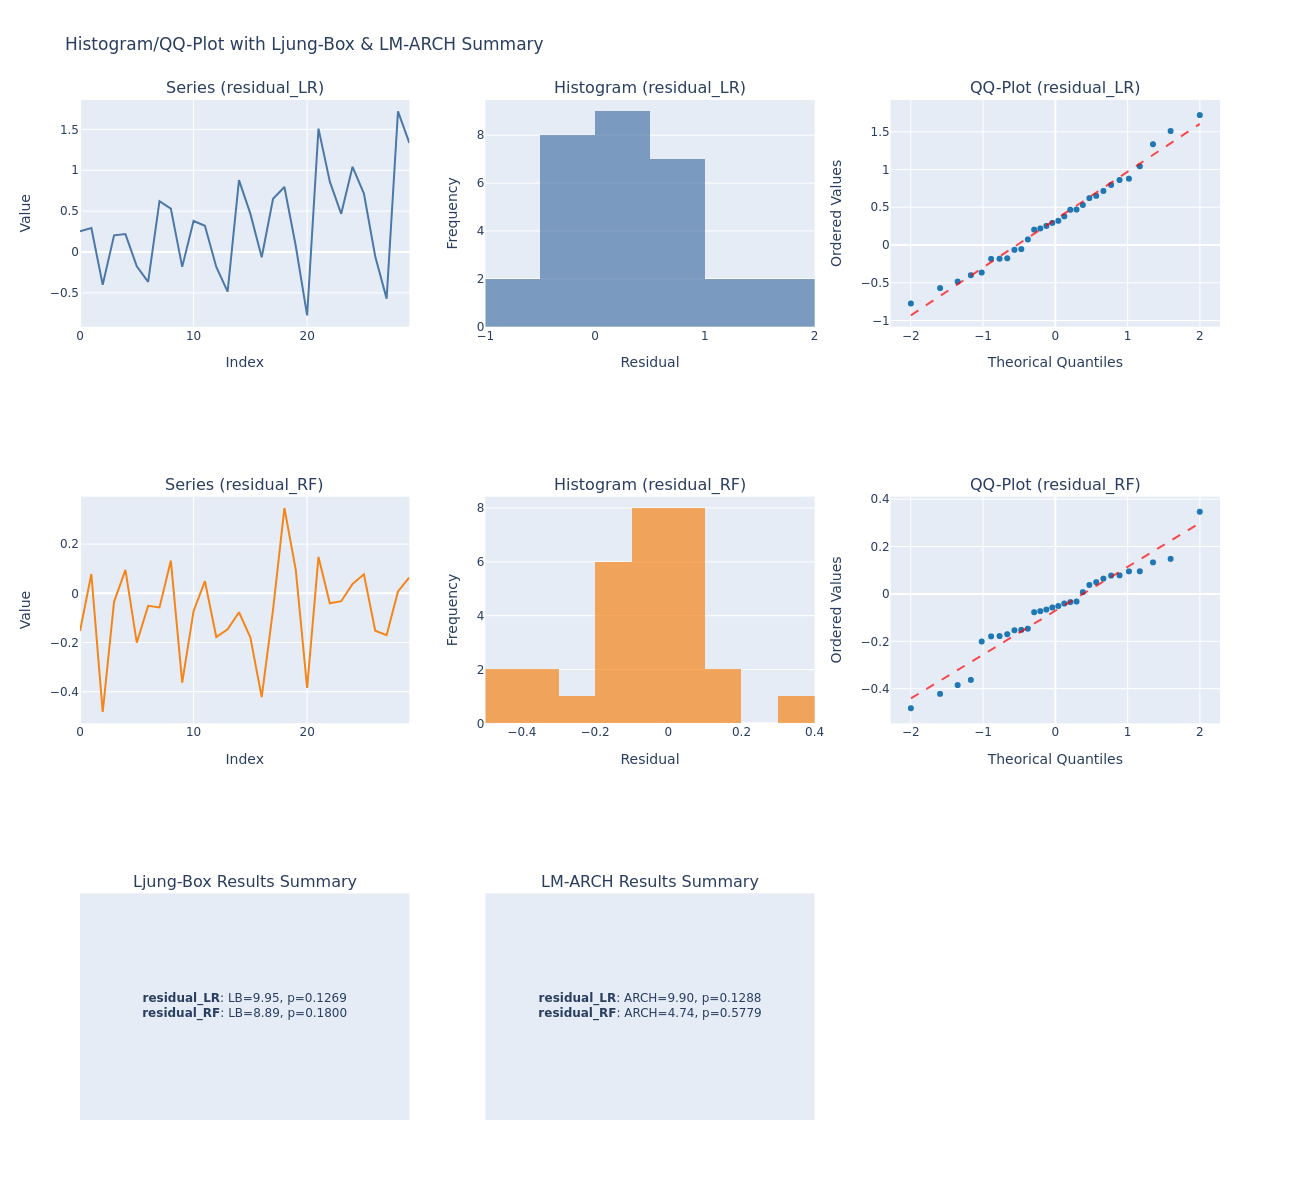

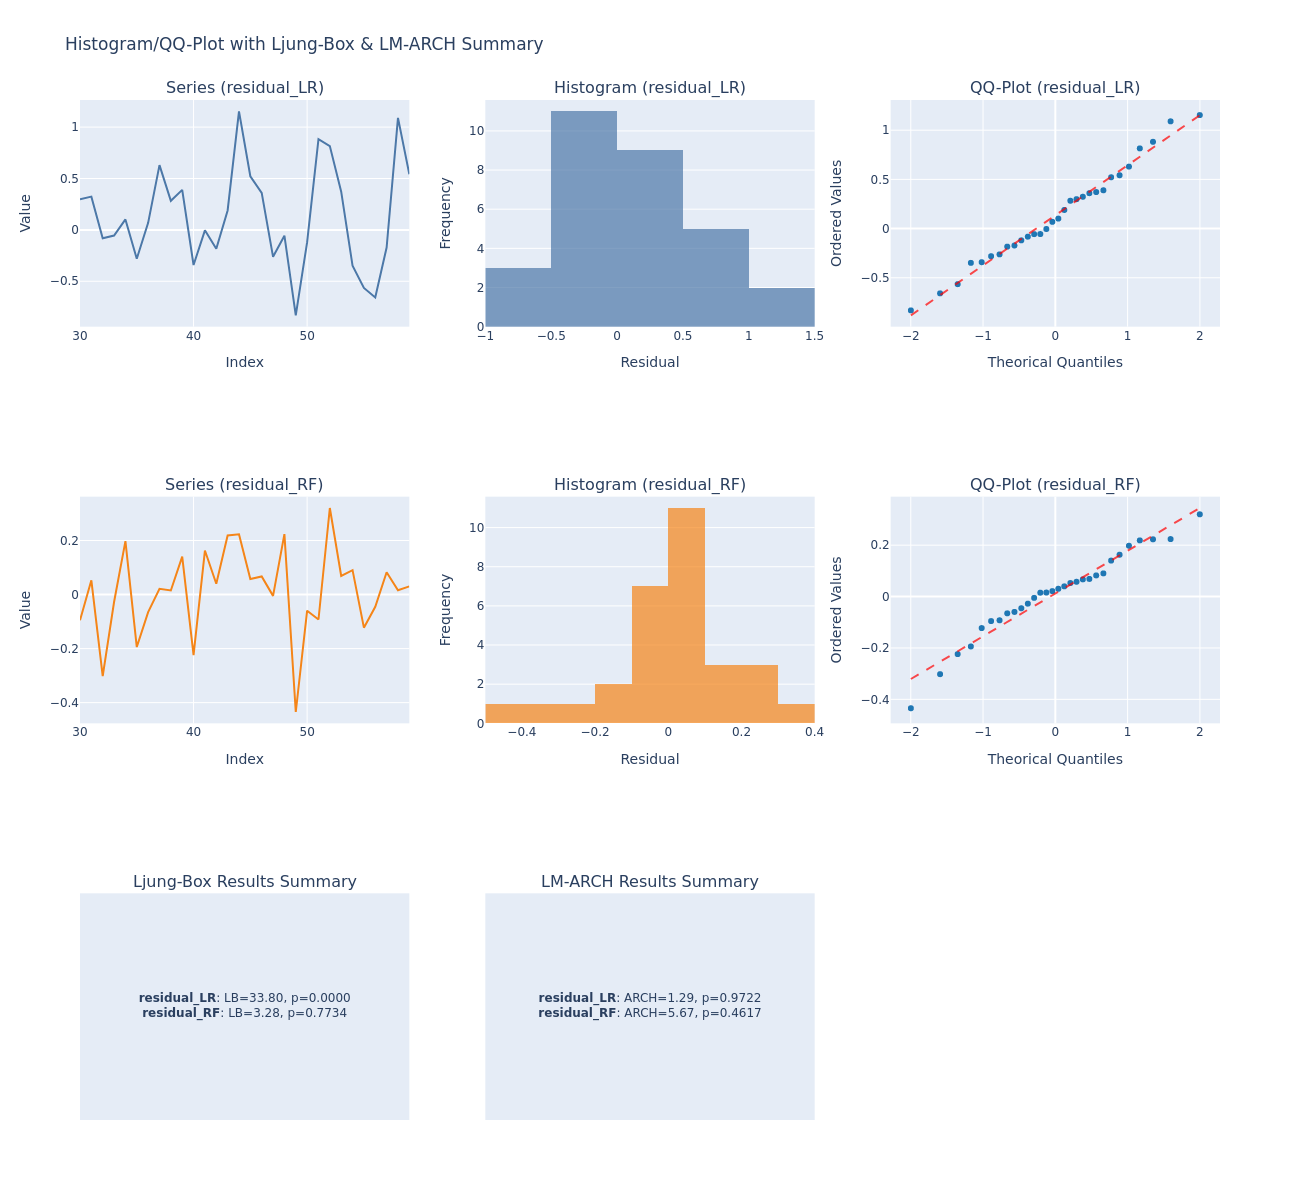

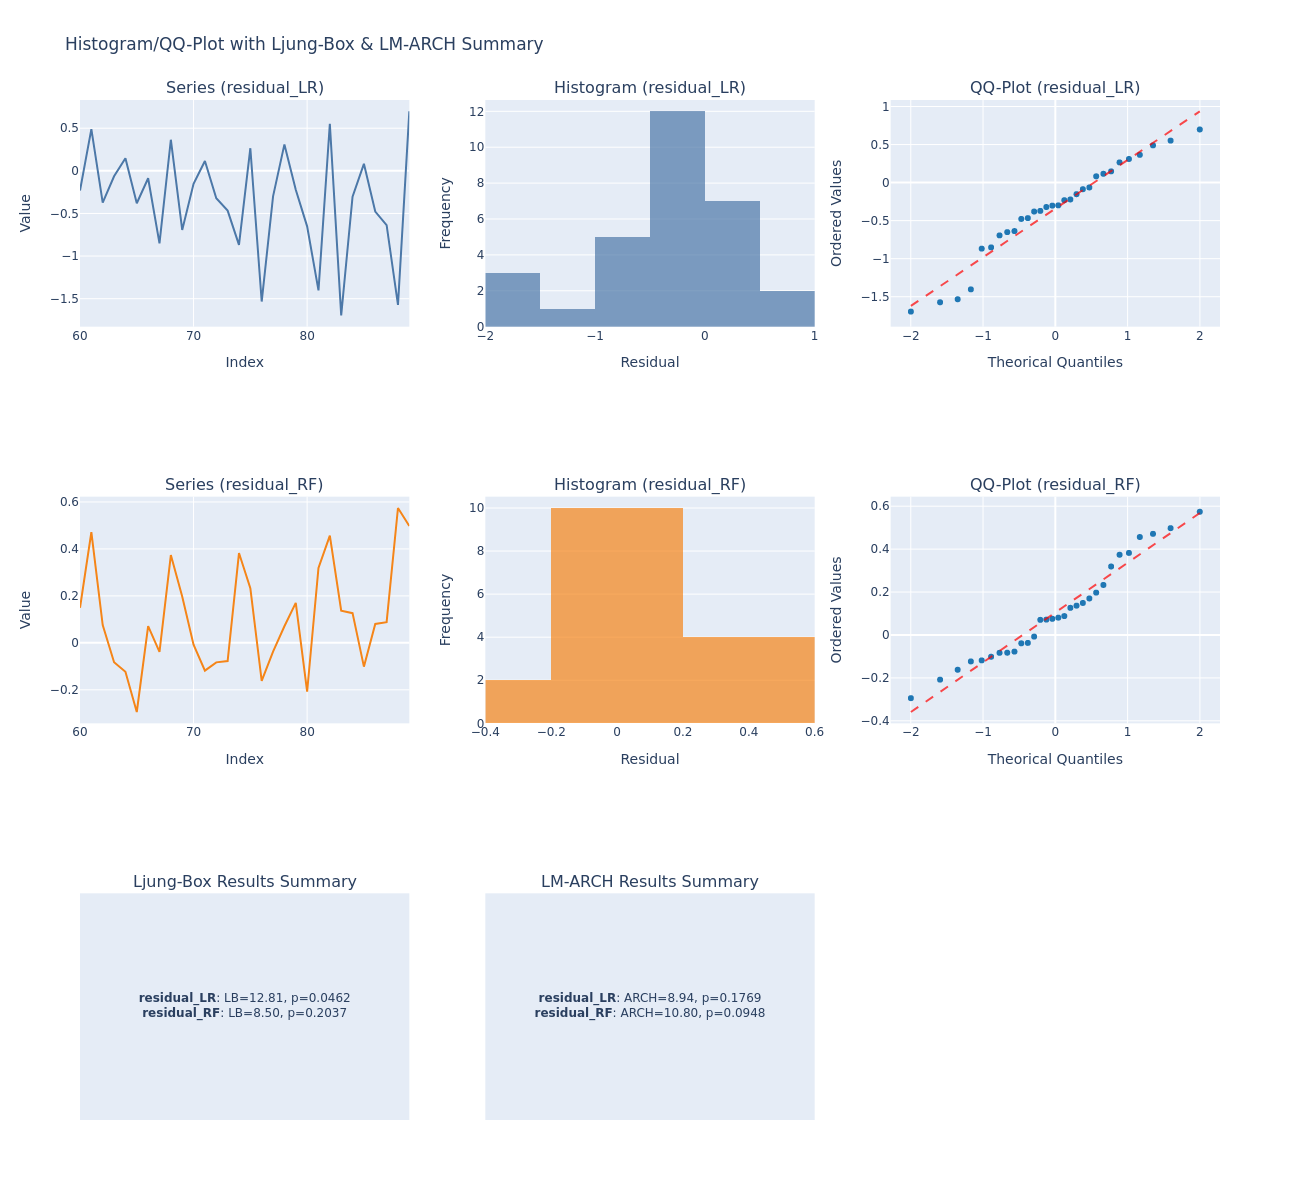

In [247]:
for id in test["unique_id"].unique():
    residual_check(test.loc[test["unique_id"] == id, ["residual_LR", "residual_RF"]], fig_type="png")

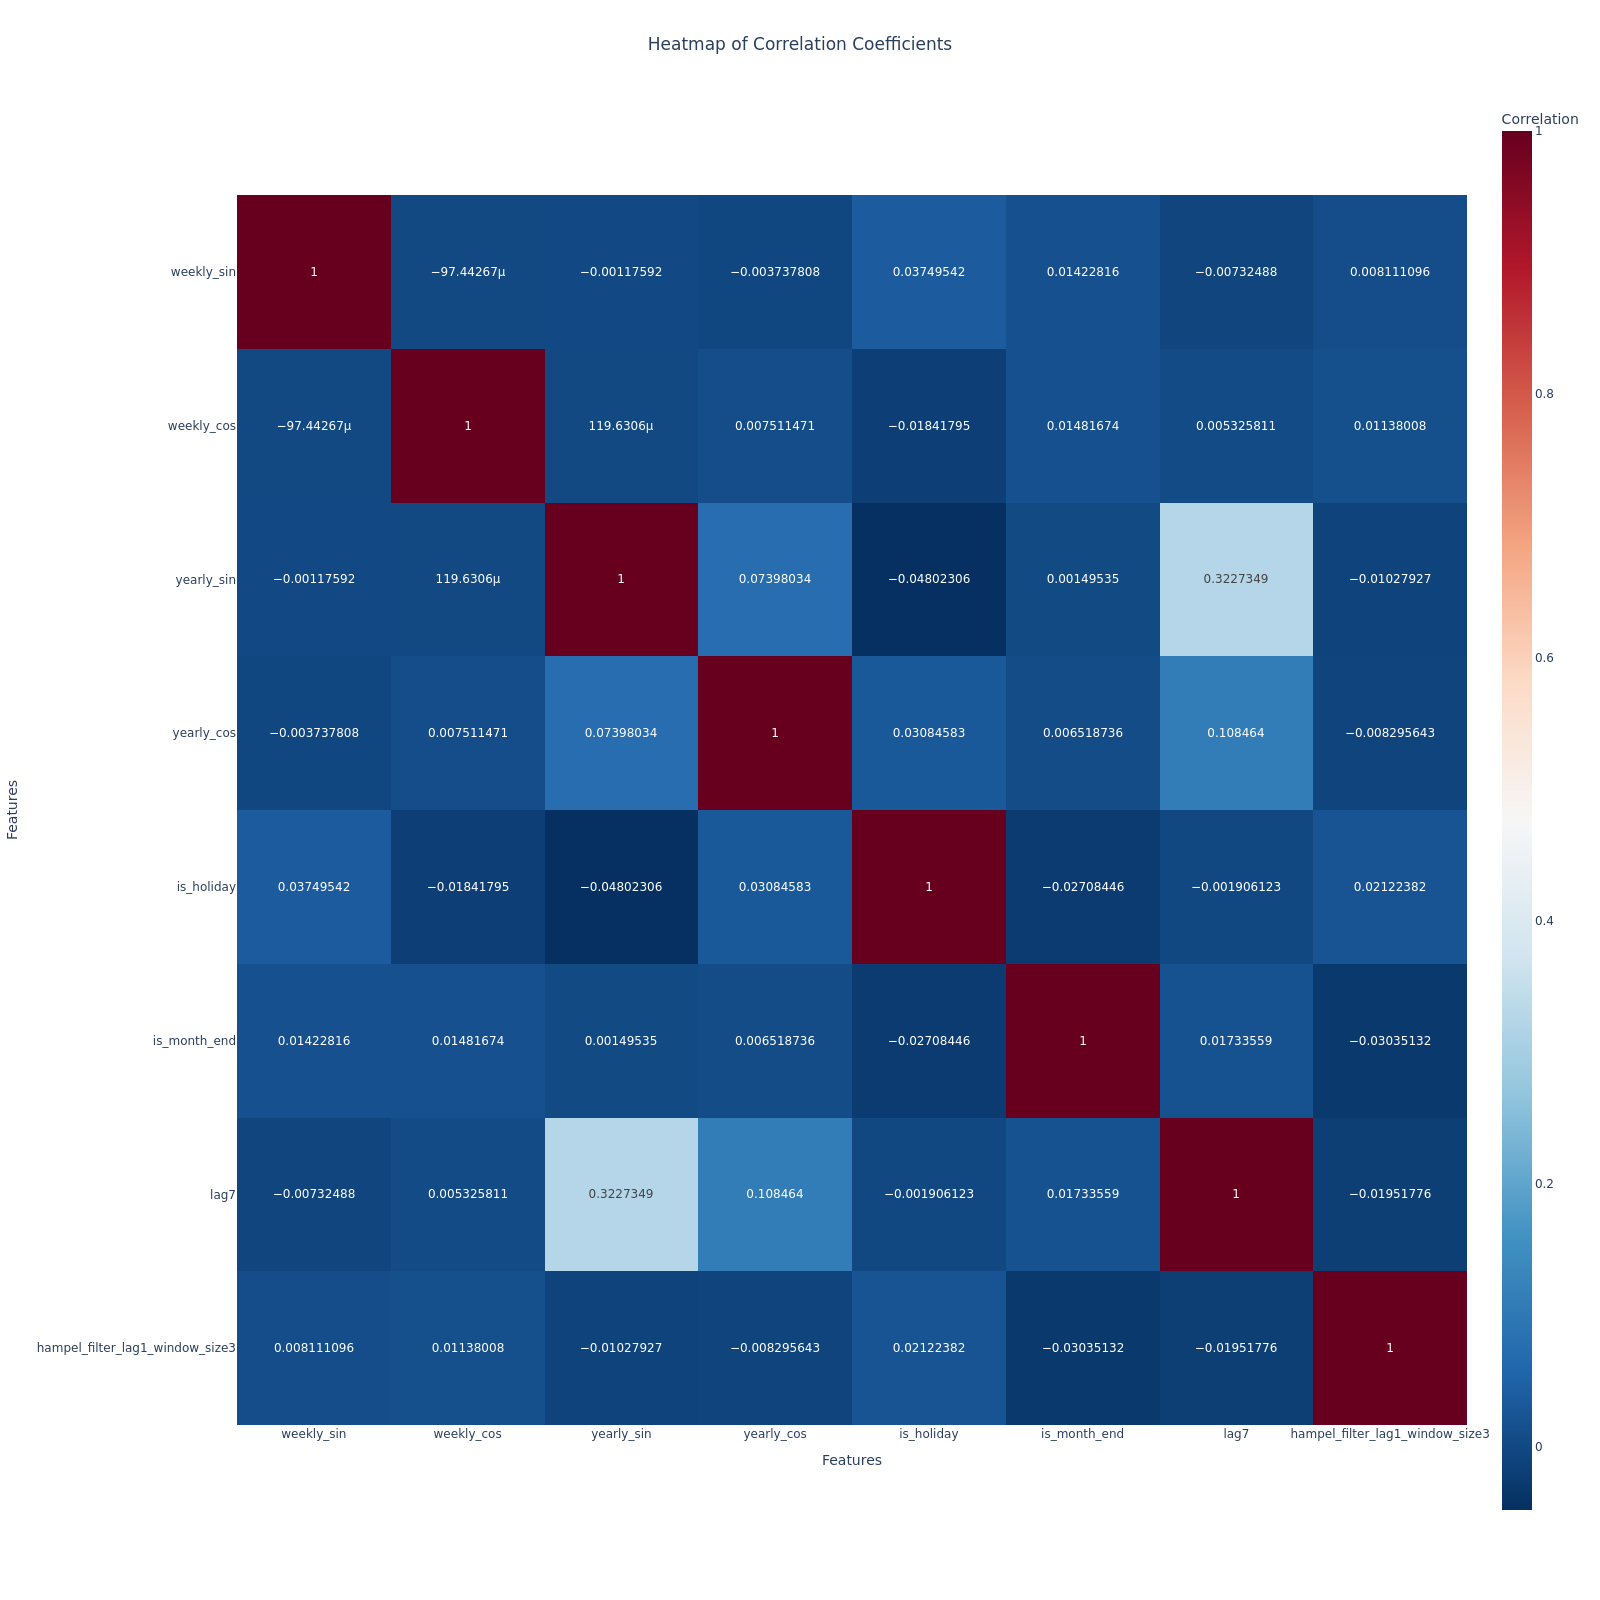

In [248]:
corr_heatmap(mf.preprocess(train, static_features=[]).drop(columns=["unique_id", "ds", "y"]), fig_type="png")

In [249]:
filter_features_by_vif(
    mf.preprocess(train, static_features=[]).drop(columns=["unique_id", "ds", "y"]),
    threshold=5.0,
    verbose=True,
)

array([ True,  True,  True,  True,  True,  True,  True,  True])

# Modelagem (Decomposição + Modelagem Residual)

1. modelo estatístico + ML residual
2. ver como fazer Tendência aditivia, sazonalidade multiplicativa
3. ver como fazer tendência aditiva, sazonalidade aditiva